In [50]:
import pandas as pd
from Main import settings, features, pf_set
import time
import pickle
import matplotlib.pyplot as plt
from pandas.tseries.offsets import DateOffset
import Prepare_Data
import data_run_files
import return_prediction_functions
from return_prediction_functions import rff
import numpy as np
from pandas.tseries.offsets import MonthEnd
from sklearn.linear_model import Ridge
import General_Functions
import pickle
import Estimate_Covariance_Matrix
import os
import prepare_portfolio_data
import portfolio_choice_functions
import scipy.linalg
import functools
import importlib
import cvxpy as cp
import seaborn as sns
sqrtm_cpp = importlib.import_module("sqrtm_cpp")
start_date = pd.to_datetime('1952-12-31')

#Relevante paths
output_path = "./data_fifty/"
pickle_file_path = "./data_fifty/model_1.pkl"
wealth_path = "./data_fifty/wealth.csv"
barra_file_path = "./data_fifty/barra_cov.pkl"
output_path_market_returns = "data_fifty/market_returns_test.csv"

risk_free_path = "./data_fifty/risk_free_test.csv" 
output_data_ret_csv = "./data_fifty/data_ret.csv"  
output_data_ret_ld1_csv = "./data_fifty/data_ret_ld1.csv"

file_path_cluster_labels = "Data/Cluster Labels.csv"
file_path_factor_details = "Data/Factor Details.xlsx"

risk_free = data_run_files.process_risk_free_rate(risk_free_path, start_date)
daily_path = "./data_fifty/daily.csv"
chars_path = "./data_fifty/chars_behandlet.parquet"


Filtrering udført. Antal rækker efter filtrering: 841
Fil gemt som ./data_test/risk_free_test.csv


In [51]:
#Folder hvor resultater og plots gemmes (hvis du kører Hede så ændrer denne for din :D)
#output_folder = r"C:\Users\jonas\OneDrive\CBS\Kandidat - CBS\Speciale\Resultater Python"
output_folder = r"C:\Users\andre\Documents\4. semester Kandidatspeciale\Billeder direkte fra koden"

## Data indlæsning

In [104]:
wealth = pd.read_csv(wealth_path)
wealth['eom'] = pd.to_datetime(wealth['eom'])
data_ret = pd.read_csv(output_data_ret_csv)
data_ret_ld1 = pd.read_csv(output_data_ret_ld1_csv)
data_ret['eom'] = pd.to_datetime(data_ret['eom'])
data_ret_ld1['eom'] = pd.to_datetime(data_ret_ld1['eom'])
data_ret_ld1['eom_ret'] = pd.to_datetime(data_ret_ld1['eom_ret'])
daily = pd.read_csv(daily_path, parse_dates=["date", "eom"])
chars = pd.read_parquet(chars_path)

In [105]:
#with open(barra_file_path, "rb") as file:
#    barra_cov = pickle.load(file)

In [106]:
import pickle

# Angiv stien til din pickle-fil med barra_cov1
pickle_path = r"C:\Users\andre\Documents\4. semester Kandidatspeciale\Data\barra_cov1.pkl"

# Indlæs den gemte struktur
with open(pickle_path, "rb") as f:
    barra_cov = pickle.load(f)

# Antag at 'barra_cov1' er din indlæste struktur (fx fra pickle)
for date, comp in barra_cov.items():
    # For fct_load: sæt 'id'-kolonnen som index, hvis den findes
    if 'id' in comp['fct_load'].columns:
        comp['fct_load'] = comp['fct_load'].set_index('id')
    # For fct_cov: sæt 'rowname'-kolonnen som index, hvis den findes
    if 'rowname' in comp['fct_cov'].columns:
        comp['fct_cov'] = comp['fct_cov'].set_index('rowname')
    # For ivol_vec: konverter DataFrame med kolonnerne 'id' og 'ivol' til en Series
    if isinstance(comp['ivol_vec'], type(comp['ivol_vec'])) and 'id' in comp['ivol_vec'].columns:
        comp['ivol_vec'] = comp['ivol_vec'].set_index('id')['ivol']



In [62]:
print(barra_cov['2022-11-30']['ivol_vec'])

id
10104   0.00404192
10107   0.00239241
10138   0.00299584
10696   0.00369609
11308   0.00127879
           ...    
87299   0.00410543
87432   0.00353400
87447   0.00313976
87717   0.00316605
92655   0.00255370
Name: ivol, Length: 180, dtype: float64


In [48]:
# tilføjels af nye predictions

In [49]:
def add_return_predictions(chars, settings, get_from_path_model):
    for h in range(1, 2):  # Hardcoded: 1 horizon
        file_path = os.path.join(get_from_path_model, f"demeaned_model_{h}.pkl")
        with open(file_path, 'rb') as f:
            model_dict = pickle.load(f)  # Indlæs pickle-fil

        # Ekstraher og fjern den månedlige gennemsnits-dataFrame fra model_dict
 #       monthly_means_df = model_dict["monthly_means_df"]
 #       del model_dict["monthly_means_df"]

        # Iterer over dato-nøgler og udtræk forudsigelser
        all_preds = []
        for date_key, subdict in model_dict.items():
            # Antag at hver subdictionary indeholder en key "pred"
            pred_df = pd.DataFrame(subdict['pred'])
            all_preds.append(pred_df)
            
        # Saml alle forudsigelsesdata
        pred_df_all = pd.concat(all_preds, ignore_index=True)
        pred_df_all = pred_df_all[['id', 'eom', 'pred']].rename(columns={'pred': f'pred_ld{h}'})
        
        # Først merge de de-meanede forudsigelser ind i chars
        chars = chars.merge(pred_df_all, on=['id', 'eom'], how='left')
        # Dernæst merge monthly means (gennemsnitsafkast) ind i chars baseret på 'eom'
   #     chars = chars.merge(monthly_means_df, on='eom', how='left')
        # Tilføj det månedlige gennemsnitsafkast til de de-meanede forudsigelser for at få den endelige prediction
        # Fjern eventuelt mean_ret-kolonnen, hvis du ikke behøver den
    #    chars = chars.drop(columns=['mean_ret'])
        
    return chars


In [55]:
chars = add_return_predictions(chars,settings, output_path)

In [56]:
chars.shape

(73216, 131)

In [57]:
#chars = prepare_portfolio_data.add_return_predictions(chars,settings, output_path)
lambda_list = prepare_portfolio_data.create_lambda_list(chars)
first_cov_date, hp_years, start_oos = prepare_portfolio_data.define_important_dates(barra_cov, settings)
date_ranges = prepare_portfolio_data.create_date_ranges(settings, first_cov_date, start_oos, hp_years)
dates_m1 = date_ranges["dates_m1"]
dates_m2 = date_ranges["dates_m2"]
dates_oos = date_ranges["dates_oos"]
dates_hp = date_ranges["dates_hp"]
#Disse er alle korrekte

#### Check af barra cov

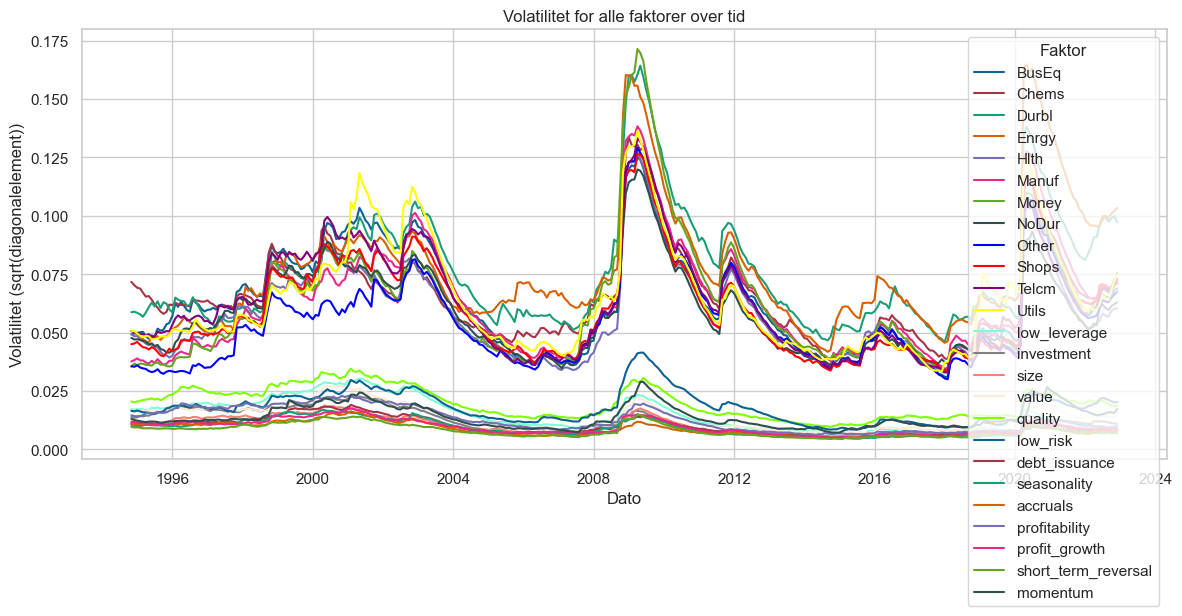

In [63]:
# Sorter datoerne
dates = sorted(barra_cov.keys())

# Hent faktornavne fra fct_cov for den første dato
first_date = dates[0]
factor_names = barra_cov[first_date]['fct_cov'].columns.tolist()

# Saml data: for hver dato og for hver faktor udregnes volatiliteten (sqrt af diagonalelementet)
records = []
for date in dates:
    df = barra_cov[date]['fct_cov']
    for factor in factor_names:
        vol = np.sqrt(df.loc[factor, factor])
        records.append({'date': pd.to_datetime(date), 'factor': factor, 'vol': vol})

# Konverter listen til en DataFrame
vol_data = pd.DataFrame(records)

# Plot: lav en linje for hver faktor over tid
plt.figure(figsize=(12, 6))
for factor in factor_names:
    subset = vol_data[vol_data['factor'] == factor]
    plt.plot(subset['date'], subset['vol'], label=factor)

plt.title("Volatilitet for alle faktorer over tid")
plt.xlabel("Dato")
plt.ylabel("Volatilitet (sqrt(diagonalelement))")
plt.legend(title="Faktor")
plt.tight_layout()
plt.show()


## Portfolio metrics funktioner

In [64]:
def calculate_portfolio_metrics(tpf):
    """
    Udregner porteføljens nøgletal ud fra tpf['pf']-DataFrame.
    
    Returnerer en ordbog med nøgletal:
      - r_yearly: Årligt gennemsnitligt afkast
      - std_yearly: Årlig standardafvigelse
      - SR_gross_yearly: Årlig Sharpe ratio (brutto)
      - tc_yearly: Årlige transaktionsomkostninger
      - r_tc_yearly: Årligt afkast efter transaktionsomkostninger
      - SR_net_yearly: Årlig Sharpe ratio (netto)
      - inv: Gennemsnitlig investering
      - Shorting: Gennemsnitligt shorting
      - Turnover: Gennemsnitligt turnover
    """
    pf = tpf['pf']
    r_yearly = np.mean(pf['r']) * 12
    std_yearly = pf['r'].std() * np.sqrt(12)
    SR_gross_yearly = (np.mean(pf['r']) / pf['r'].std()) * np.sqrt(12)
    tc_yearly = np.mean(pf['tc']) * 12
    r_tc_yearly = np.mean(pf['r'] - pf['tc']) * 12
    SR_net_yearly = (np.mean(pf['r'] - pf['tc']) / pf['r'].std()) * np.sqrt(12)
    inv_mean = np.mean(pf['inv'])
    shorting_mean = np.mean(pf['shorting'])
    turnover_mean = np.mean(pf['turnover'])
    
    return {
        "r_yearly": r_yearly,
        "std_yearly": std_yearly,
        "SR_gross_yearly": SR_gross_yearly,
        "tc_yearly": tc_yearly,
        "r_tc_yearly": r_tc_yearly,
        "SR_net_yearly": SR_net_yearly,
        "inv": inv_mean,
        "Shorting": shorting_mean,
        "Turnover": turnover_mean
    }

def compare_portfolio_metrics(tpf_original, tpf_new):
    """
    Sammenligner nøgletal for to porteføljer (tpf_original og tpf_new)
    og returnerer en DataFrame med kolonnerne "Metric", "Original" og "New".
    """
    metrics_orig = calculate_portfolio_metrics(tpf_original)
    metrics_new = calculate_portfolio_metrics(tpf_new)
    
    df_results = pd.DataFrame({
        "Metric": list(metrics_orig.keys()),
        "Markowitz-ML": list(metrics_orig.values()),
        "Markowitz-ML TC optimeret": list(metrics_new.values())
    })
    
    return df_results


# Markowitz optimeringen (OG version uden trade cost opt) - resultater og plots

In [65]:
tpf_original = portfolio_choice_functions.tpf_implement(data=chars, cov_list=barra_cov, wealth=wealth, dates=dates_oos, gam=pf_set["gamma_rel"])

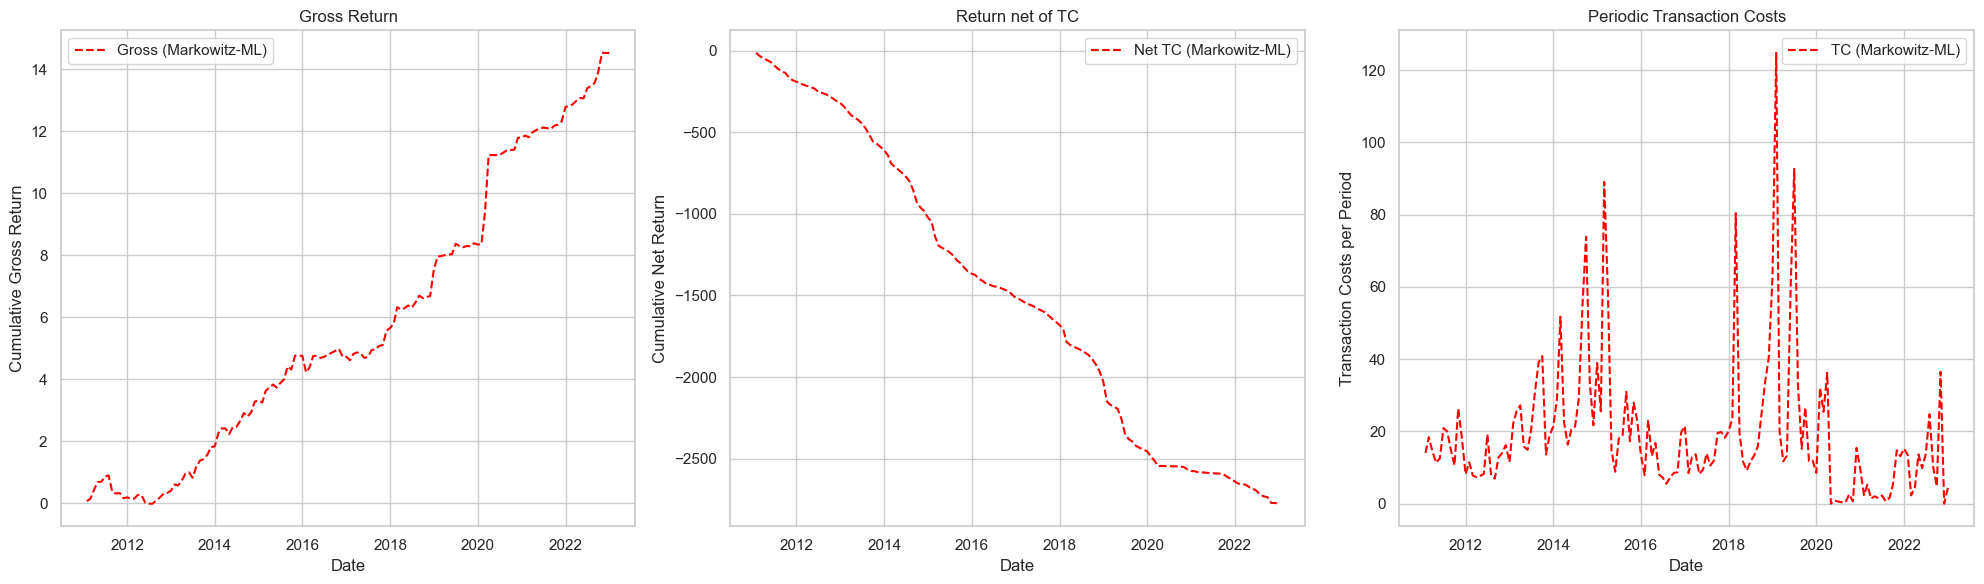

In [66]:
# Kopier dataframe for Markowitz-ML
tpf_data = tpf_original["pf"].copy()

# Beregn kumulative afkast for Markowitz-ML
tpf_data['cumret'] = tpf_data['r'].cumsum()
tpf_data['cumret_tc'] = (tpf_data['r'] - tpf_data['tc']).cumsum()

# Opret 3 subplots: Gross Return, Return net of TC og Periodiske Transaction Costs
fig, axes = plt.subplots(1, 3, figsize=(20, 6))

# --- Plot 1: Gross Return ---
ax = axes[0]
ax.plot(tpf_data['eom_ret'], tpf_data['cumret'], label='Gross (Markowitz-ML)', color='red', linestyle='--')
ax.set_xlabel('Date')
ax.set_ylabel('Cumulative Gross Return')
ax.set_title('Gross Return')
ax.grid(True)
ax.legend()

# --- Plot 2: Return net of TC ---
ax = axes[1]
ax.plot(tpf_data['eom_ret'], tpf_data['cumret_tc'], label='Net TC (Markowitz-ML)', color='red', linestyle='--')
ax.set_xlabel('Date')
ax.set_ylabel('Cumulative Net Return')
ax.set_title('Return net of TC')
ax.grid(True)
ax.legend()

# --- Plot 3: Periodiske Transaction Costs ---
ax = axes[2]
ax.plot(tpf_data['eom_ret'], tpf_data['tc'], label='TC (Markowitz-ML)', color='red', linestyle='--')
ax.set_xlabel('Date')
ax.set_ylabel('Transaction Costs per Period')
ax.set_title('Periodic Transaction Costs')
ax.grid(True)
ax.legend()

plt.tight_layout()
plt.show()


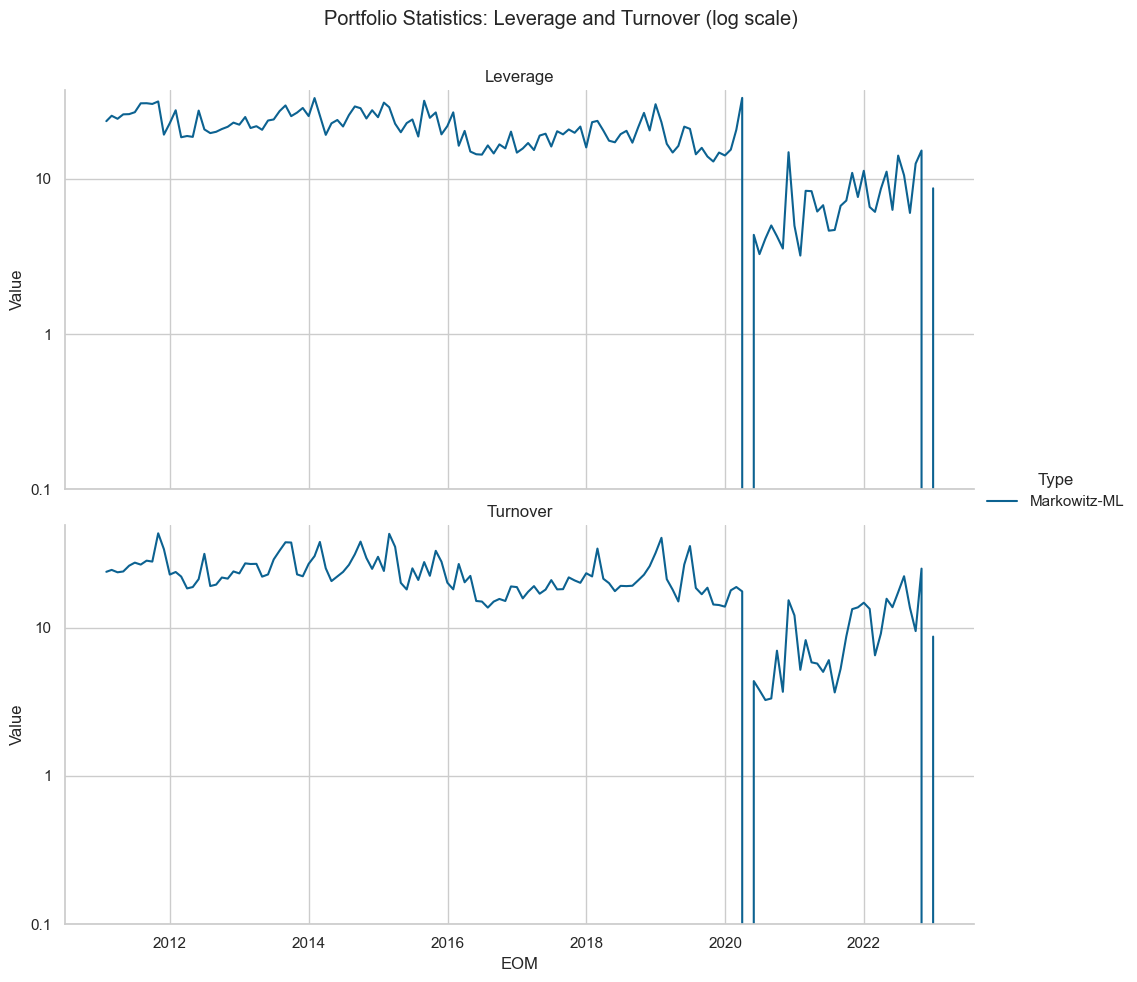

In [67]:
# 1. Kopier data for Markowitz-ML
tpf_pf = tpf_original['pf'].copy()

# 2. Sæt type-kolonnen til "Markowitz-ML"
tpf_pf["type"] = "Markowitz-ML"

# 3. Vælg de relevante kolonner: eom_ret, inv og turnover (samt type)
ws = tpf_pf[['eom_ret', 'inv', 'turnover', 'type']].copy()

# 4. Omdøb eom_ret til eom for korthed
ws.rename(columns={'eom_ret': 'eom'}, inplace=True)

# 5. Konverter til long format, så vi kan plotte Leverage og Turnover i separate paneler
ws_long = ws.melt(
    id_vars=['type', 'eom'],
    value_vars=['inv', 'turnover'],
    var_name='metric',
    value_name='value'
)

# 6. Omdøb metric-værdier til pænere navne
ws_long['metric'] = ws_long['metric'].map({
    'inv': 'Leverage',
    'turnover': 'Turnover'
})

# 7. Plot med Seaborn's FacetGrid
g = sns.FacetGrid(ws_long, col="metric", col_wrap=1, sharey=False, height=5, aspect=2)
g.map_dataframe(sns.lineplot, x="eom", y="value", hue="type", style="type")

# Sæt y-aksen til log-skala
g.set(yscale="log")

# Fjern "metric = " i facettitlen
g.set_titles("{col_name}")

# Tilføj en fælles legend
g.add_legend(title="Type")

# Angiv egne ticks på y-aksen
for ax in g.axes.flatten():
    ax.set_yticks([0.1, 1, 10])
    ax.set_yticklabels(['0.1', '1', '10'])

# Sæt akse-labels og en overordnet titel
g.set_axis_labels("EOM", "Value")
plt.subplots_adjust(top=0.9)
g.fig.suptitle("Portfolio Statistics: Leverage and Turnover (log scale)")

plt.show()


# Markowitz-ML med transactions cost optimering

Ny optimering med både minimering af transaktionsomkostninger samt begrænsning på de optimale vægte

In [68]:
def w_fun_qpstyle(tpf_opt, data, wealth, dates):
    """
    Genskaber logikken fra w_fun, men bruger QP-vægtene i tpf_opt.
    For hver dato t bliver w_start(t) = w_final(t-1) * (1 + tr_ld1(t-1)) / (1 + mu_ld1(t-1)).
    """
    # 1) Sikr at (id, eom) er unikke i tpf_opt
    tpf_opt = tpf_opt.drop_duplicates(subset=['id','eom'])

    # 2) For at få tr_ld1 og mu_ld1 for "forrige" dato, 
    #    laver vi merges med data og wealth, men rename eom -> eom_prev
    data_prev = data[['id','eom','tr_ld1']].drop_duplicates(subset=['id','eom'])
    data_prev = data_prev.rename(columns={'eom':'eom_prev','tr_ld1':'tr_ld1_prev'})
    
    wealth_prev = wealth[['eom','mu_ld1']].drop_duplicates(subset=['eom'])
    wealth_prev = wealth_prev.rename(columns={'eom':'eom_prev','mu_ld1':'mu_ld1_prev'})
    
    # 3) Omdøb w til w_prev og eom til eom_prev => "forrige" periodes w
    w_prev = tpf_opt.rename(columns={'w':'w_prev','eom':'eom_prev'})
    w_prev = w_prev.drop_duplicates(subset=['id','eom_prev'])

    # 4) Merge w_prev med data_prev og wealth_prev
    w_prev = pd.merge(w_prev, data_prev, on=['id','eom_prev'], how='left')
    w_prev = pd.merge(w_prev, wealth_prev, on='eom_prev', how='left')
    # Nu har w_prev kolonner: [id, eom_prev, w_prev, tr_ld1_prev, mu_ld1_prev]

    # 5) Lav en DataFrame med (eom, eom_prev) for at matche "nuværende" eom med forrige eom
    dates_df = pd.DataFrame({'eom': dates})
    dates_df['eom_prev'] = dates_df['eom'].shift(1)

    # 6) Merge tpf_opt (den "nuværende" w) med dates_df for at få eom_prev
    w_df = pd.merge(tpf_opt, dates_df, on='eom', how='left')
    # w_df har [id, eom, w, eom_prev]

    # 7) Merge w_df med w_prev (dvs. forrige måneds w + tr_ld1_prev, mu_ld1_prev)
    w_df = pd.merge(w_df, w_prev, on=['id','eom_prev'], how='left')
    # w_df har nu: [id, eom, w, eom_prev, w_prev, tr_ld1_prev, mu_ld1_prev]

    # 8) Beregn w_start for den nuværende dato:
    #    w_start(t) = w_prev(t-1) * (1 + tr_ld1_prev)/(1 + mu_ld1_prev)
    #    Hvis eom_prev er NaN (første dato), sæt w_start = np.nan eller initiel vægt
    w_df['w_start'] = w_df['w_prev'] * (1 + w_df['tr_ld1_prev']) / (1 + w_df['mu_ld1_prev'])
    #w_df['w_start'] = w_df['w_prev'] * (1 + w_df['tr_ld1']) / (1 + w_df['mu_ld1'])

    
    # For første dato i 'dates', eom_prev er NaN => w_start bliver NaN
    # Du kan fx erstatte med initiale vægte (VW) for den første dato:
    first_date = dates[0]
    init_w = General_Functions.initial_weights_new(data[data['eom'] == first_date], w_type="vw")[['id','w_start']]
    # Merge for at få init_w
    w_df = pd.merge(w_df, init_w, on='id', how='left', suffixes=('', '_init'))
    # Hvor eom == first_date, brug w_start_init
    w_df.loc[w_df['eom'] == first_date, 'w_start'] = w_df.loc[w_df['eom'] == first_date, 'w_start_init']
    missing = w_df['w_start'].isna()
    w_df.loc[missing, 'w_start'] = 0
    #w_df.loc[missing, ['tr_ld1_prev','mu_ld1_prev']] = np.nan
    #w_df['w_start'] = w_df['w_start'].fillna(0)

    # 9) Merge nu tr_ld1 og mu_ld1 for *den nuværende* dato (ikke prev) - hvis du ønsker dem i output
    # 9) Merge tr_ld1 og mu_ld1 for den forrige periode
    data_subset_shifted = data[['id','eom','tr_ld1']].drop_duplicates(subset=['id','eom'])
    data_subset_shifted = data_subset_shifted.rename(columns={'eom': 'eom_prev'})
    wealth_subset_shifted = wealth[['eom','mu_ld1']].drop_duplicates(subset=['eom'])
    wealth_subset_shifted = wealth_subset_shifted.rename(columns={'eom': 'eom_prev'})
    w_df = pd.merge(w_df, data_subset_shifted, on=['id','eom_prev'], how='left')
    w_df = pd.merge(w_df, wealth_subset_shifted, on='eom_prev', how='left')
    w_df.loc[missing, ['tr_ld1','mu_ld1']] = np.nan


    #Ændret!!!
    #w_df.loc[w_df['eom'] == first_date, ['tr_ld1', 'mu_ld1']] = np.nan

    # 10) Ryd op i kolonnerne, så vi får det endelige format
    w_df = w_df[['id','eom','w_start','w','tr_ld1','mu_ld1']]

    return w_df


In [69]:
def optimize_with_bounds_and_penalty(w_opt, w_start, lam, alpha, delta):
    """
    Løser QP:
        min_w alpha * sum_i (w_i - w_opt_i)^2
              + (1 - alpha)* sum_i [ lam_i * (w_i - w_start_i)^2 ]
        s.t.   w_opt_i - delta <= w_i <= w_opt_i + delta
               sum_i w_i = 1
    Parametre:
      - w_opt: Numpy-array (størrelse n) med "klassiske" optimale vægte
      - w_start: Numpy-array (størrelse n) med forrige periodes vægte
      - lam: Numpy-array (størrelse n) med transaktionsomkostningsparametre
      - alpha: Vægt for at blive tæt på w_opt (0 <= alpha <= 1)
      - delta: Maksimal afvigelse fra w_opt
    Returnerer:
      - w_final: Numpy-array (størrelse n) med de endelige vægte
    """
    n = len(w_opt)
    w = cp.Variable(n)

    # Objektfunktion: alpha*||w - w_opt||^2 + (1-alpha)*sum(lam_i*(w_i - w_start_i)^2)
    # sum_squares(...) = \sum_i (x_i)^2
    obj = alpha * cp.sum_squares(w - w_opt) \
          + (1 - alpha) * cp.sum(cp.multiply(lam, cp.square(w - w_start)))

    # Begrænsninger
    constraints = [
        w >= w_opt - delta,
        w <= w_opt + delta,
        cp.sum(w) == 1
        # evt. w >= 0 hvis du vil have long-only
    ]

    prob = cp.Problem(cp.Minimize(obj), constraints)
    prob.solve(solver=cp.OSQP)  # eller en anden solver

    if w.value is None:
        raise ValueError("Kunne ikke løse QP-problemet.")
    return w.value

# Eksempel på brug for én dato:
# w_final = optimize_with_bounds_and_penalty(w_opt, w_start, lam, alpha=0.5, delta=0.2)


In [70]:
def tpf_implement_qp(data, cov_list, wealth, dates, gam, delta, alpha):
    """
    Beregner porteføljevægte dato-for-dato med:
      - Klassisk Markowitz-ML til at finde w_opt,
      - En QP, der sikrer at w_final ligger inden for ±delta af w_opt,
      - Og som minimerer en kombineret objektfunktion:
            alpha * ||w - w_opt||^2  +  (1 - alpha) * sum(lam * (w - w_start)^2)
        hvor w_start er den afkastjusterede vægt fra forrige periode.
        
    Parametre:
      - data: DataFrame med aktiedata
      - cov_list: dictionary med kovariansmatricer (nøgle: dato)
      - wealth: DataFrame med wealth og mu_ld1 (for hver dato)
      - dates: liste over datoer
      - gam: risikoaversion parameter
      - delta: maks. afvigelse fra w_opt (f.eks. 0.2)
      - alpha: vægtning mellem at holde sig tæt på w_opt og minimere transaktionsomkostninger
      
    Returnerer:
      - tpf_opt: DataFrame med kolonnerne ['id', 'eom', 'w'] for hver dato.
    """
    # Filtrer og sorter data
    data_rel = data[(data['valid'] == True) & (data['eom'].isin(dates))][['id', 'eom', 'me', 'tr_ld1', 'pred_ld1']]
    data_rel = data_rel.sort_values(by=['id', 'eom'])
    data_split = {d: df for d, df in data_rel.groupby('eom')}

    # Helper-funktion til afkastjustering af w_prev
    def adjust_w_prev_for_returns(w_prev_series, df_current, wealth_current):
        df_current = df_current.set_index('id')
        w_prev_aligned = w_prev_series.reindex(df_current.index).fillna(0)
        tr_ld1 = df_current['tr_ld1']
        mu_ld1 = wealth_current['mu_ld1'].iloc[0]  # antager én værdi pr. dato
        return w_prev_aligned * (1 + tr_ld1) / (1 + mu_ld1)

    tpf_opt_list = []
    
    # For den første dato: brug initiale VW-vægte
    first_date = dates[0]
    data_first = data_split[first_date]
    init_w = General_Functions.initial_weights_new(data_first, w_type="vw")
    # Sørg for at gemme som Series med id som index
    w_prev_final = pd.Series(init_w['w_start'].values, index=init_w['id'])

    for d in dates:
        # Lav nøglen til cov_list
        d_key = d.strftime('%Y-%m-%d') if isinstance(d, pd.Timestamp) else d
        data_sub = data_split.get(d)
        if data_sub is None or data_sub.empty:
            continue

        ids = data_sub['id'].tolist()
        sigma = General_Functions.create_cov(cov_list[d_key], ids=ids)
        pred_vector = data_sub['pred_ld1'].values

        # 1) Beregn klassisk w_opt
        w_opt = (1 / gam) * np.linalg.solve(sigma, pred_vector)

        # 2) Juster w_prev_final for afkast
        wealth_d = wealth.loc[wealth['eom'] == d]
        w_start = adjust_w_prev_for_returns(w_prev_final, data_sub, wealth_d)

        # 3) Lav QP med kombineret objektfunktion:
        #    alpha * ||w - w_opt||^2  +  (1 - alpha)* sum(lam*(w - w_start)^2)
        lam = data_sub['lambda'].values if 'lambda' in data_sub.columns else np.ones_like(w_opt)
        n = len(w_opt)
        w = cp.Variable(n)
        obj = alpha * cp.sum_squares(w - w_opt) \
              + (1 - alpha) * cp.sum(cp.multiply(lam, cp.square(w - w_start)))
        constraints = [
            w >= w_opt - delta,
            w <= w_opt + delta,
            cp.sum(w) == 1
            # evt. tilføj w >= 0 hvis long-only ønskes
        ]
        prob = cp.Problem(cp.Minimize(obj), constraints)
        prob.solve(solver=cp.OSQP)

        if w.value is None:
            raise ValueError(f"Optimeringsproblemet for dato {d} kunne ikke løses.")
        w_final = w.value

        # 4) Gem resultater for denne dato
        temp_df = data_sub[['id', 'eom']].copy()
        temp_df['w'] = w_final
        tpf_opt_list.append(temp_df)

        # 5) Opdater w_prev_final til næste iteration som en Series med index = id
        w_prev_final = pd.Series(w_final, index=data_sub['id'])

    # Saml resultaterne
    if tpf_opt_list:
        tpf_opt = pd.concat(tpf_opt_list, ignore_index=True)
    else:
        tpf_opt = pd.DataFrame(columns=['id','eom','w'])

    # Du kan eventuelt køre en efterfølgende funktion (w_fun_post) for yderligere behandling.
    tpf_w = w_fun_post(tpf_opt, data, wealth)
    return tpf_opt  # eller returnér en dict med både "w" og "pf"

def w_fun_post(tpf_opt, data, wealth):
    """
    Enkel version af w_fun - returnerer blot tpf_opt.
    """
    return tpf_opt


In [71]:
def run_markowitz_qp_pipeline(data, cov_list, wealth, dates, gam, delta, alpha):
    # 1) Kør QP for at få endelige vægte (med kombineret objektfunktion)
    tpf_opt = tpf_implement_qp(data, cov_list, wealth, dates, gam, delta=delta, alpha=alpha)
    
    # 2) Skab w-df med w_start, tr_ld1, mu_ld1 osv.
    tpf_w = w_fun_qpstyle(tpf_opt, data, wealth, dates)
    
    # 3) Beregn porteføljestatistikker
    tpf_pf = General_Functions.pf_ts_fun(tpf_w, data, wealth, gam)
    
    return {
        "w": tpf_w,
        "pf": tpf_pf
    }

# Eksempel på kald:
tpf_trans = run_markowitz_qp_pipeline(
    data=chars, 
    cov_list=barra_cov, 
    wealth=wealth, 
    dates=dates_oos, 
    gam=pf_set["gamma_rel"],
    delta=0.3,   # Sørger for, at vi ikke afviger med mere end ± delta fra w_opt
    alpha=0    # Juster alpha alt efter, hvor meget der forankres i w_opt vs. minimere TC
    #Hvis alpha = 1, så bliver løsningen så tæt den optimale portefølje uanset trade cost
    #Hvis alpha = 0, så fokuseres der udelukkende på at minimere transaktionsomkostninger
    #delta angiver hvor meget man må afvige fra de optimale vægte
    #Generelt skal vi bare holde alpha lig 0
)


# Relevante plots og stats for Original MVO vs trade cost optimeret MVO

In [72]:
df_metrics = compare_portfolio_metrics(tpf_original, tpf_trans)
display(df_metrics)
latex_table = df_metrics.to_latex(index=False, float_format="%.4f", caption="Sammenligning af porteføljemålepunkter", label="tab:portfolio_metrics")
print(latex_table)
latex_table = df_metrics.set_index("Metric").T.to_latex(
    float_format="%.4f",
    caption="Sammenligning af porteføljemålepunkter (transponeret)",
    label="tab:portfolio_metrics_transposed"
)
print(latex_table)

Metric  Markowitz-ML  Markowitz-ML TC optimeret
0         r_yearly    1.21077138                 0.06481360
1       std_yearly    0.85102509                 0.43837972
2  SR_gross_yearly    1.42272114                 0.14784808
3        tc_yearly  232.51205228                16.51439533
4      r_tc_yearly -231.30128090               -16.44958173
5    SR_net_yearly -271.79137792               -37.52359184
6              inv   18.50795912                10.77190294
7         Shorting    9.12207076                 4.89289591
8         Turnover   20.22118802                 2.39982078

\begin{table}
\caption{Sammenligning af porteføljemålepunkter}
\label{tab:portfolio_metrics}
\begin{tabular}{lrr}
\toprule
Metric & Markowitz-ML & Markowitz-ML TC optimeret \\
\midrule
r_yearly & 1.2108 & 0.0648 \\
std_yearly & 0.8510 & 0.4384 \\
SR_gross_yearly & 1.4227 & 0.1478 \\
tc_yearly & 232.5121 & 16.5144 \\
r_tc_yearly & -231.3013 & -16.4496 \\
SR_net_yearly & -271.7914 & -37.5236 \\
inv & 18.5080 & 10.7719 \\
Shorting & 9.1221 & 4.8929 \\
Turnover & 20.2212 & 2.3998 \\
\bottomrule
\end{tabular}
\end{table}

\begin{table}
\caption{Sammenligning af porteføljemålepunkter (transponeret)}
\label{tab:portfolio_metrics_transposed}
\begin{tabular}{lrrrrrrrrr}
\toprule
Metric & r_yearly & std_yearly & SR_gross_yearly & tc_yearly & r_tc_yearly & SR_net_yearly & inv & Shorting & Turnover \\
\midrule
Markowitz-ML & 1.2108 & 0.8510 & 1.4227 & 232.5121 & -231.3013 & -271.7914 & 18.5080 & 9.1221 & 20.2212 \\
Markowitz-ML TC optimeret & 0.0648 & 0.4384 & 0.1478 & 16.5144 & -16.4496 & -37.523

### Plot af gross return, net-return og periodisk tc (Markowitz-ML og Markowitz-ML trade cost optimized)

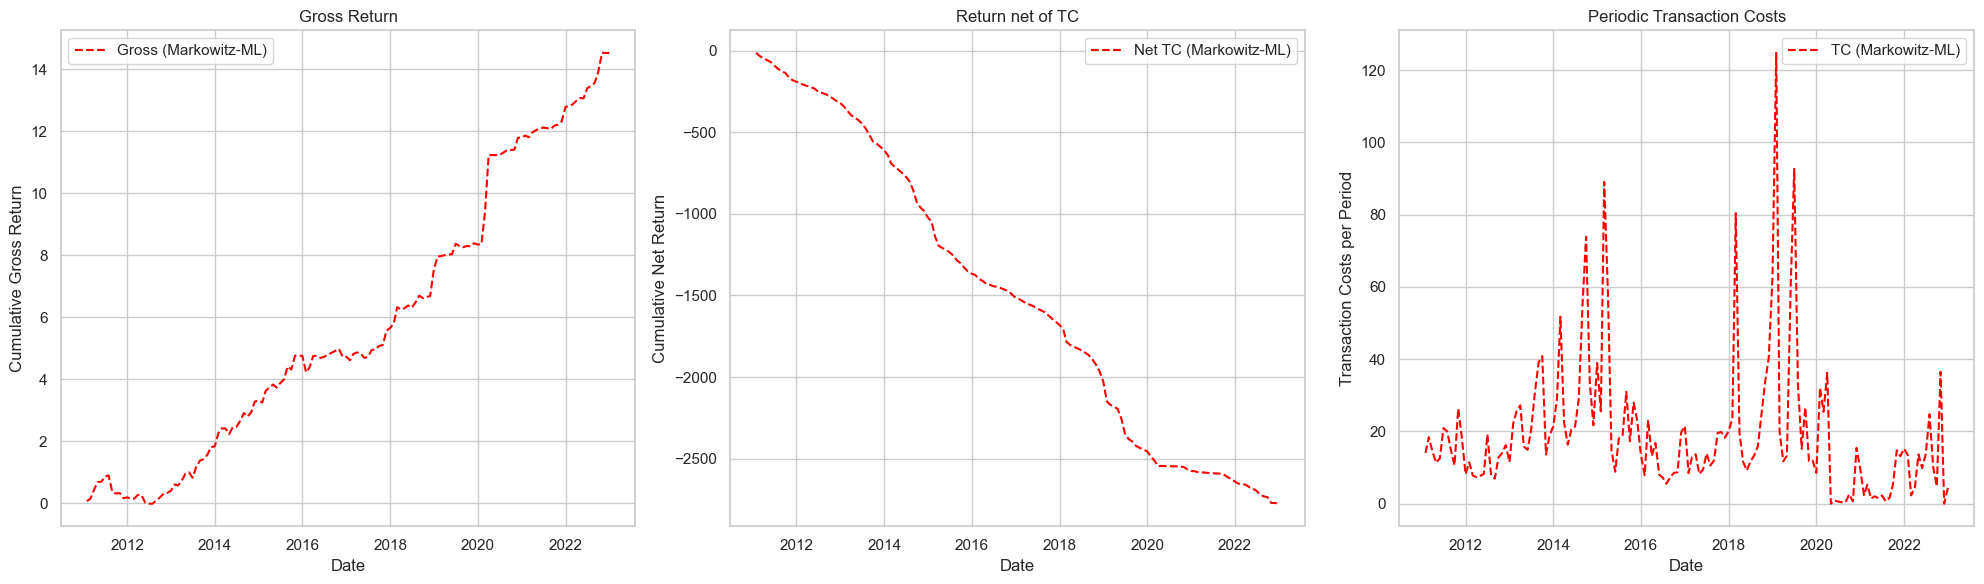

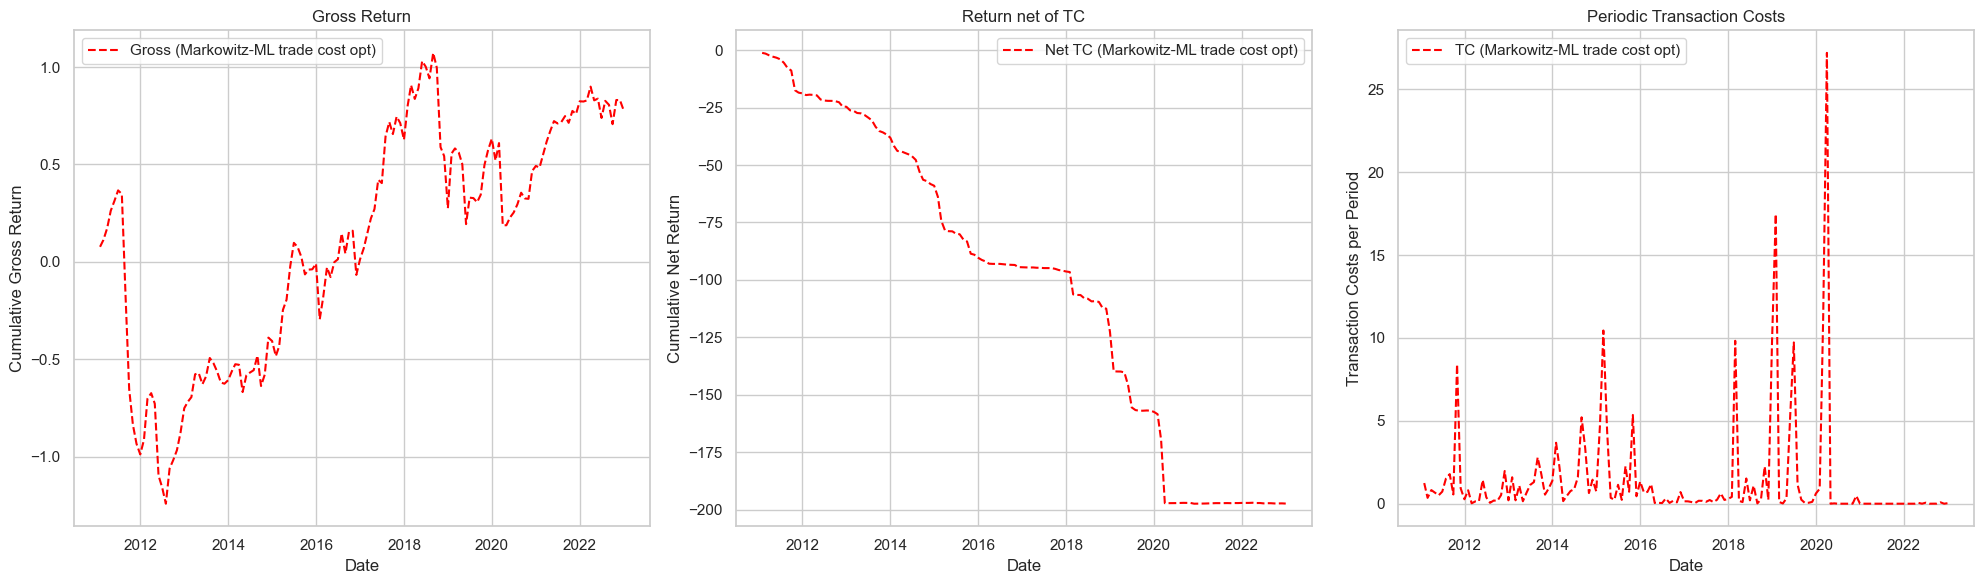

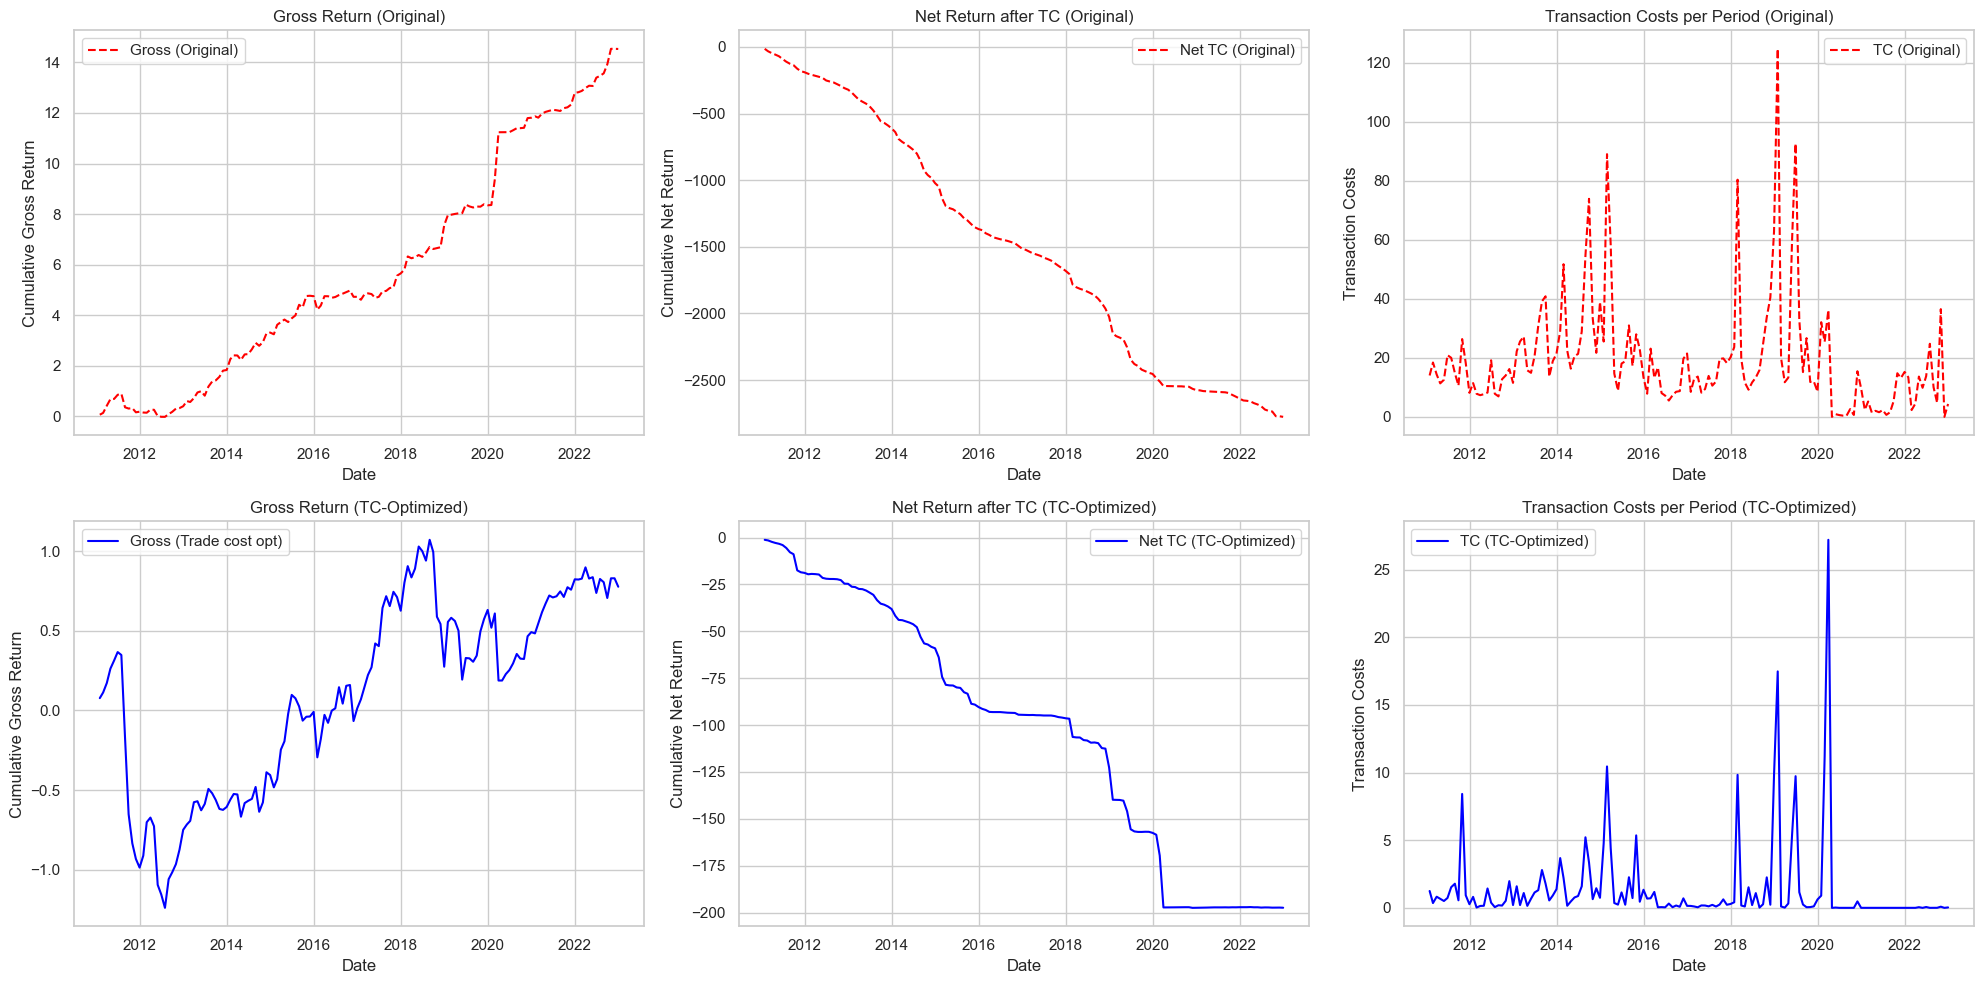

In [73]:
# Kopier dataframe for Markowitz-ML
tpf_data = tpf_original["pf"].copy()

# Beregn kumulative afkast for Markowitz-ML
tpf_data['cumret'] = tpf_data['r'].cumsum()
tpf_data['cumret_tc'] = (tpf_data['r'] - tpf_data['tc']).cumsum()

tpf_data_new = tpf_trans["pf"].copy()

# Beregn kumulative afkast for Markowitz-ML
tpf_data_new['cumret'] = tpf_data_new['r'].cumsum()
tpf_data_new['cumret_tc'] = (tpf_data_new['r'] - tpf_data_new['tc']).cumsum()

# Opret 3 subplots: Gross Return, Return net of TC og Periodiske Transaction Costs
fig, axes = plt.subplots(1, 3, figsize=(20, 6))

# --- Plot 1: Gross Return ---
ax = axes[0]
ax.plot(tpf_data['eom_ret'], tpf_data['cumret'], label='Gross (Markowitz-ML)', color='red', linestyle='--')
ax.set_xlabel('Date')
ax.set_ylabel('Cumulative Gross Return')
ax.set_title('Gross Return')
ax.grid(True)
ax.legend()

# --- Plot 2: Return net of TC ---
ax = axes[1]
ax.plot(tpf_data['eom_ret'], tpf_data['cumret_tc'], label='Net TC (Markowitz-ML)', color='red', linestyle='--')
ax.set_xlabel('Date')
ax.set_ylabel('Cumulative Net Return')
ax.set_title('Return net of TC')
ax.grid(True)
ax.legend()

# --- Plot 3: Periodiske Transaction Costs ---
ax = axes[2]
ax.plot(tpf_data['eom_ret'], tpf_data['tc'], label='TC (Markowitz-ML)', color='red', linestyle='--')
ax.set_xlabel('Date')
ax.set_ylabel('Transaction Costs per Period')
ax.set_title('Periodic Transaction Costs')
ax.grid(True)
ax.legend()

plt.tight_layout()
plt.savefig(os.path.join(output_folder, "markowitz_ml_original.png"), dpi=300, bbox_inches='tight')
plt.show()

# Opret 3 subplots: Gross Return, Return net of TC og Periodiske Transaction Costs
fig, axes = plt.subplots(1, 3, figsize=(20, 6))
# --- Plot 1: Gross Return ---
ax = axes[0]
ax.plot(tpf_data['eom_ret'], tpf_data_new['cumret'], label='Gross (Markowitz-ML trade cost opt)', color='red', linestyle='--')
ax.set_xlabel('Date')
ax.set_ylabel('Cumulative Gross Return')
ax.set_title('Gross Return')
ax.grid(True)
ax.legend()

# --- Plot 2: Return net of TC ---
ax = axes[1]
ax.plot(tpf_data['eom_ret'], tpf_data_new['cumret_tc'], label='Net TC (Markowitz-ML trade cost opt)', color='red', linestyle='--')
ax.set_xlabel('Date')
ax.set_ylabel('Cumulative Net Return')
ax.set_title('Return net of TC')
ax.grid(True)
ax.legend()

# --- Plot 3: Periodiske Transaction Costs ---
ax = axes[2]
ax.plot(tpf_data['eom_ret'], tpf_data_new['tc'], label='TC (Markowitz-ML trade cost opt)', color='red', linestyle='--')
ax.set_xlabel('Date')
ax.set_ylabel('Transaction Costs per Period')
ax.set_title('Periodic Transaction Costs')
ax.grid(True)
ax.legend()

plt.tight_layout()
plt.savefig(os.path.join(output_folder, "markowitz_ml_trans_opt.png"), dpi=300, bbox_inches='tight')
plt.show()

# Beregn kumulative afkast for begge
tpf_data = tpf_original["pf"].copy()
tpf_data['cumret'] = tpf_data['r'].cumsum()
tpf_data['cumret_tc'] = (tpf_data['r'] - tpf_data['tc']).cumsum()

tpf_data_new = tpf_trans["pf"].copy()
tpf_data_new['cumret'] = tpf_data_new['r'].cumsum()
tpf_data_new['cumret_tc'] = (tpf_data_new['r'] - tpf_data_new['tc']).cumsum()

# Opret samlet plot med 2 rækker (original og trade-cost-opt) og 3 kolonner
fig, axes = plt.subplots(2, 3, figsize=(20, 10))

# --- Øverste række: Original Markowitz-ML ---
axes[0, 0].plot(tpf_data['eom_ret'], tpf_data['cumret'], label='Gross (Original)', color='red', linestyle='--')
axes[0, 0].set_title('Gross Return (Original)')
axes[0, 0].set_xlabel('Date')
axes[0, 0].set_ylabel('Cumulative Gross Return')
axes[0, 0].legend()
axes[0, 0].grid(True)

axes[0, 1].plot(tpf_data['eom_ret'], tpf_data['cumret_tc'], label='Net TC (Original)', color='red', linestyle='--')
axes[0, 1].set_title('Net Return after TC (Original)')
axes[0, 1].set_xlabel('Date')
axes[0, 1].set_ylabel('Cumulative Net Return')
axes[0, 1].legend()
axes[0, 1].grid(True)

axes[0, 2].plot(tpf_data['eom_ret'], tpf_data['tc'], label='TC (Original)', color='red', linestyle='--')
axes[0, 2].set_title('Transaction Costs per Period (Original)')
axes[0, 2].set_xlabel('Date')
axes[0, 2].set_ylabel('Transaction Costs')
axes[0, 2].legend()
axes[0, 2].grid(True)

# --- Nederste række: Trade Cost Optimeret ---
axes[1, 0].plot(tpf_data['eom_ret'], tpf_data_new['cumret'], label='Gross (Trade cost opt)', color='blue', linestyle='-')
axes[1, 0].set_title('Gross Return (TC-Optimized)')
axes[1, 0].set_xlabel('Date')
axes[1, 0].set_ylabel('Cumulative Gross Return')
axes[1, 0].legend()
axes[1, 0].grid(True)

axes[1, 1].plot(tpf_data['eom_ret'], tpf_data_new['cumret_tc'], label='Net TC (TC-Optimized)', color='blue', linestyle='-')
axes[1, 1].set_title('Net Return after TC (TC-Optimized)')
axes[1, 1].set_xlabel('Date')
axes[1, 1].set_ylabel('Cumulative Net Return')
axes[1, 1].legend()
axes[1, 1].grid(True)

axes[1, 2].plot(tpf_data['eom_ret'], tpf_data_new['tc'], label='TC (TC-Optimized)', color='blue', linestyle='-')
axes[1, 2].set_title('Transaction Costs per Period (TC-Optimized)')
axes[1, 2].set_xlabel('Date')
axes[1, 2].set_ylabel('Transaction Costs')
axes[1, 2].legend()
axes[1, 2].grid(True)

# Fælles layout og gem
plt.tight_layout()
plt.savefig(os.path.join(output_folder, "markowitz_ml_trans_opt_combined.png"), dpi=300, bbox_inches='tight')

### Udvikling af vægte over tid for original Markowitz vs trade cost optimeret Markowitz

In [74]:
def plot_specific_ids(df, id_list=None, weight_col='w', ax=None, show_legend=True):
    """
    Plotter 'weight_col' for de ID'er, der findes i id_list.
    Hvis id_list er None, plottes alle ID'er.
    Kan også plotte direkte på given matplotlib-akse (ax).
    """
    if id_list is None:
        id_list = df['id'].unique().tolist()
    
    # Filtrér til de ønskede id'er
    df_sub = df[df['id'].isin(id_list)].copy()
    df_sub = df_sub.sort_values('eom')
    
    # Pivotér så index = eom, columns = id, values = weight_col
    pivot_df = df_sub.pivot(index='eom', columns='id', values=weight_col)

    # Plot
    if ax is not None:
        pivot_df.plot(ax=ax, legend=show_legend)
        ax.set_title(f"Udvikling i {weight_col} for ID'er")
        ax.set_xlabel("Dato")
        ax.set_ylabel(weight_col)
        if show_legend:
            ax.legend(title="ID", fontsize=9)
    else:
        pivot_df.plot(figsize=(10, 6), legend=show_legend)
        plt.title(f"Udvikling i {weight_col} for ID'er")
        plt.xlabel("Dato")
        plt.ylabel(weight_col)
        if show_legend:
            plt.legend(title="ID", fontsize=9)
        plt.show()


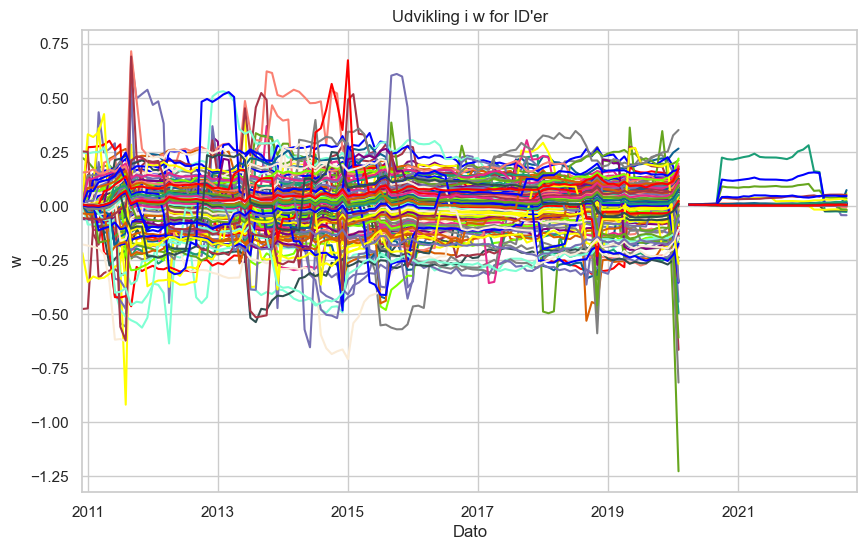

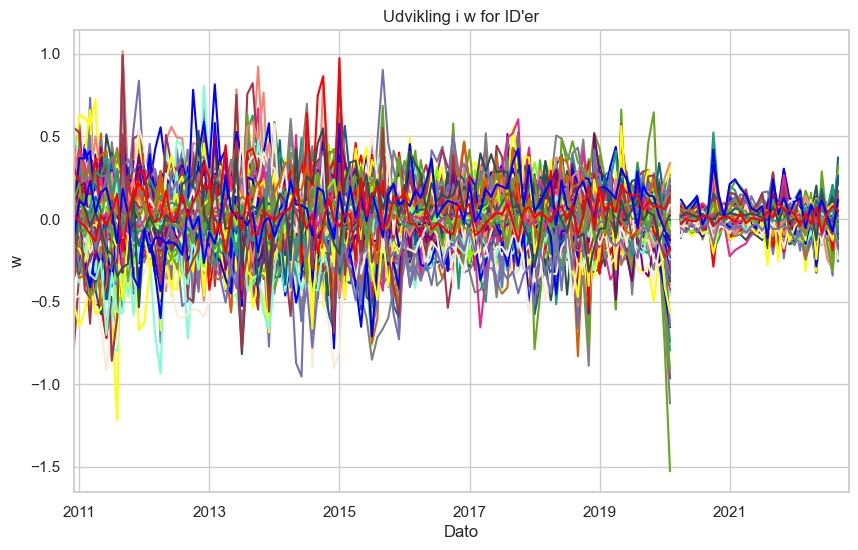

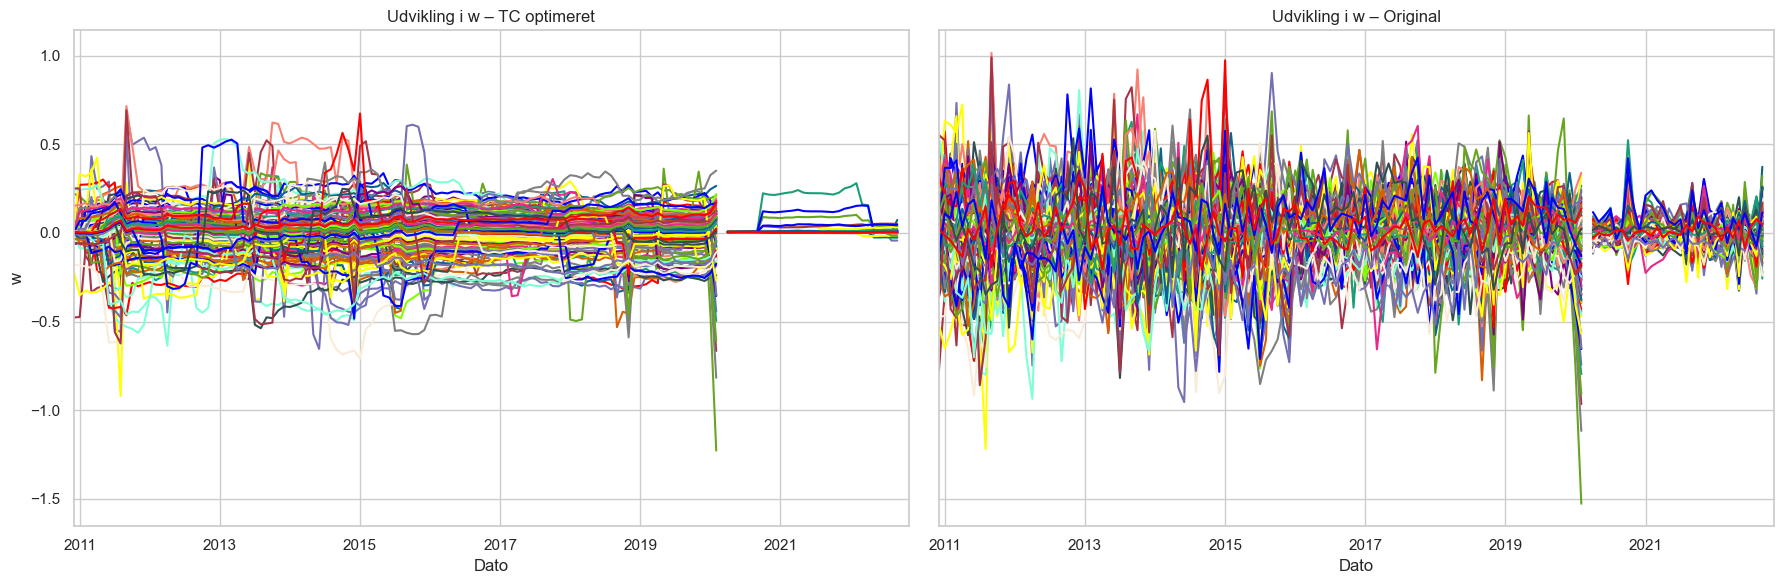

In [75]:
plot_specific_ids(tpf_trans["w"], id_list=None, weight_col='w', show_legend=False)
plot_specific_ids(tpf_original["w"], id_list=None, weight_col='w', show_legend=False)
# Opret side-by-side subplot
fig, axes = plt.subplots(1, 2, figsize=(18, 6), sharey=True)

# Plot tpf_trans (optimeret)
plot_specific_ids(tpf_trans["w"], id_list=None, weight_col="w", ax=axes[0], show_legend=False)
axes[0].set_title("Udvikling i w – TC optimeret")
axes[0].set_xlabel("Dato")
axes[0].set_ylabel("w")

# Plot tpf_original
plot_specific_ids(tpf_original["w"], id_list=None, weight_col="w", ax=axes[1], show_legend=False)
axes[1].set_title("Udvikling i w – Original")
axes[1].set_xlabel("Dato")

plt.tight_layout()
plt.savefig(os.path.join(output_folder, "w_udvikling_trans_opt"), dpi=300, bbox_inches='tight')
plt.show()

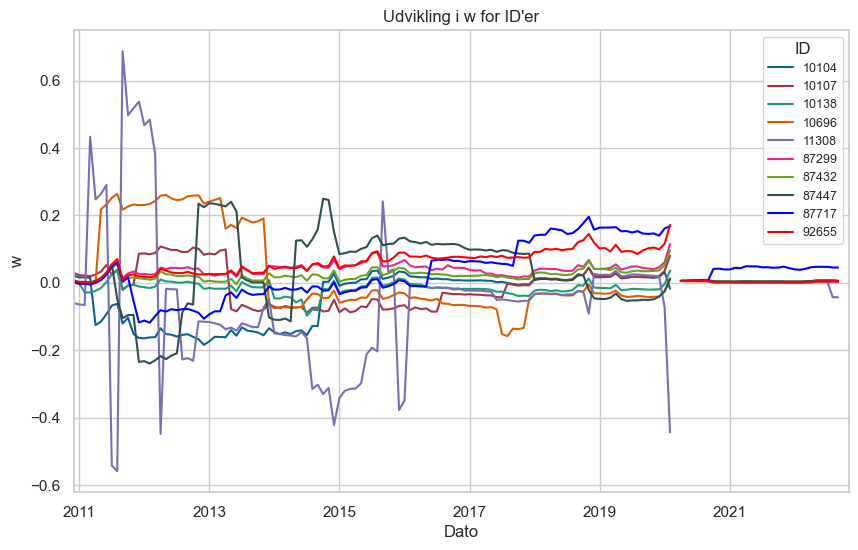

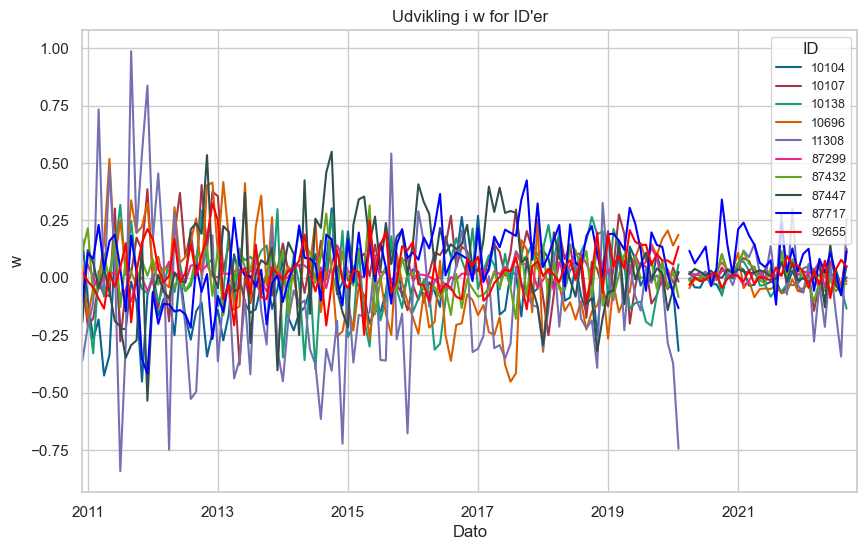

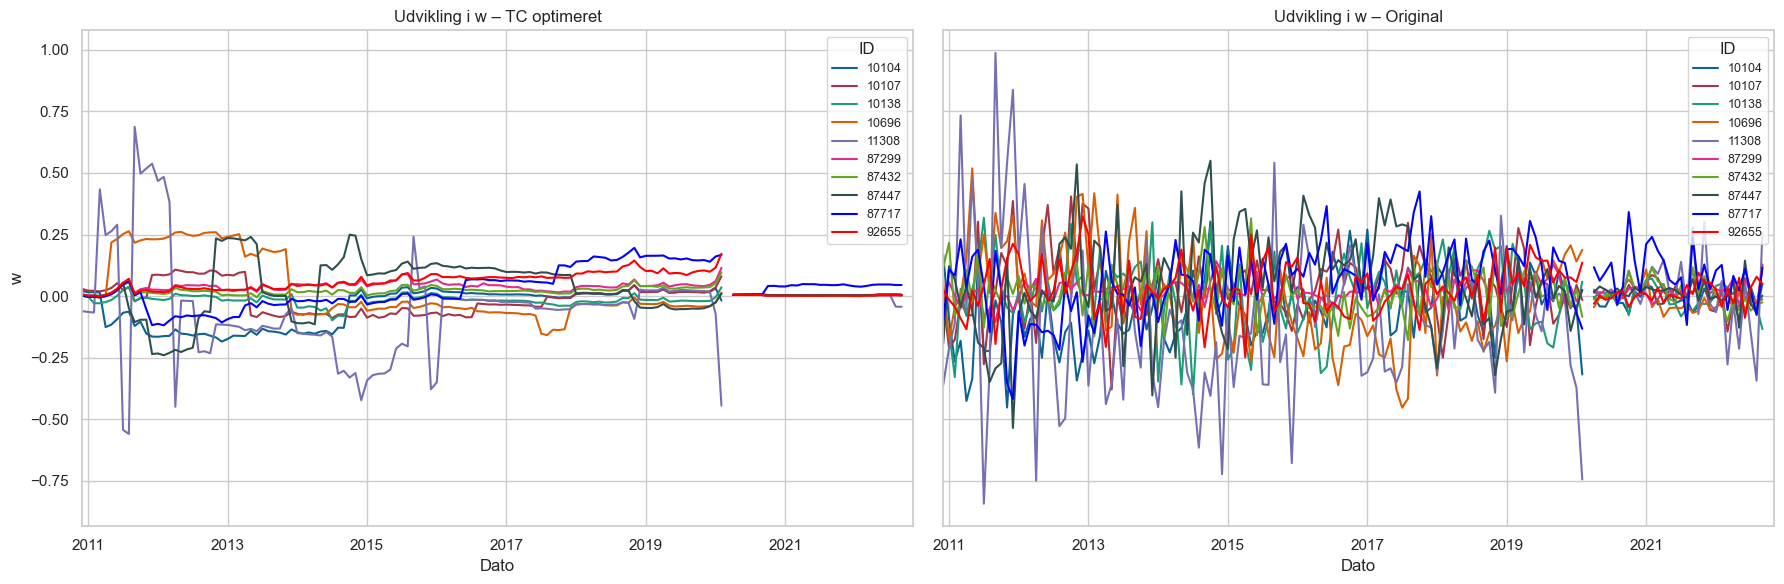

In [76]:
my_ids = [10104, 10107, 10138, 10696, 11308, 87299, 87432, 87447, 87717, 92655]
plot_specific_ids(tpf_trans["w"], my_ids, weight_col='w') 
plot_specific_ids(tpf_original["w"], my_ids, weight_col='w')  

fig, axes = plt.subplots(1, 2, figsize=(18, 6), sharey=True)

# Plot TC-optimeret
plot_specific_ids(tpf_trans["w"], my_ids, weight_col='w', ax=axes[0], show_legend=True)
axes[0].set_title("Udvikling i w – TC optimeret")
axes[0].set_xlabel("Dato")
axes[0].set_ylabel("w")

# Plot original
plot_specific_ids(tpf_original["w"], my_ids, weight_col='w', ax=axes[1], show_legend=True)
axes[1].set_title("Udvikling i w – Original")
axes[1].set_xlabel("Dato")

plt.tight_layout()
plt.savefig(os.path.join(output_folder, "w_udvikling_trans_opt_udvalgte.png"), dpi=300, bbox_inches='tight')
plt.show()


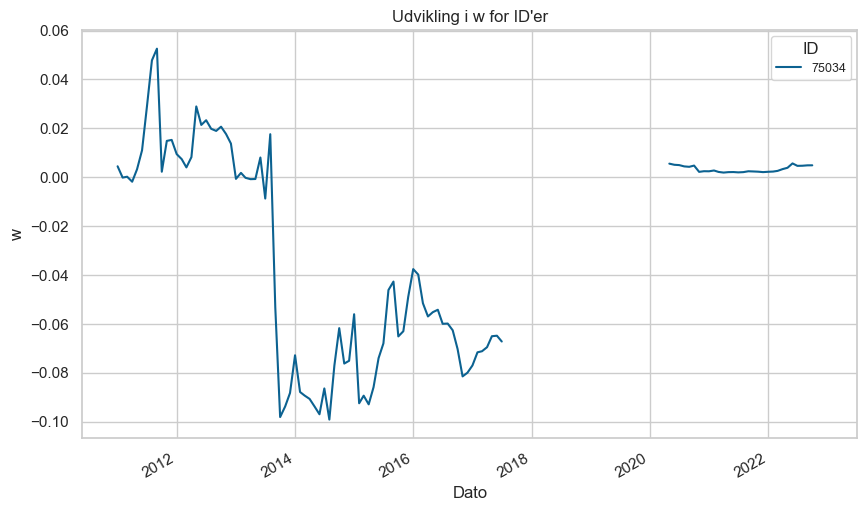

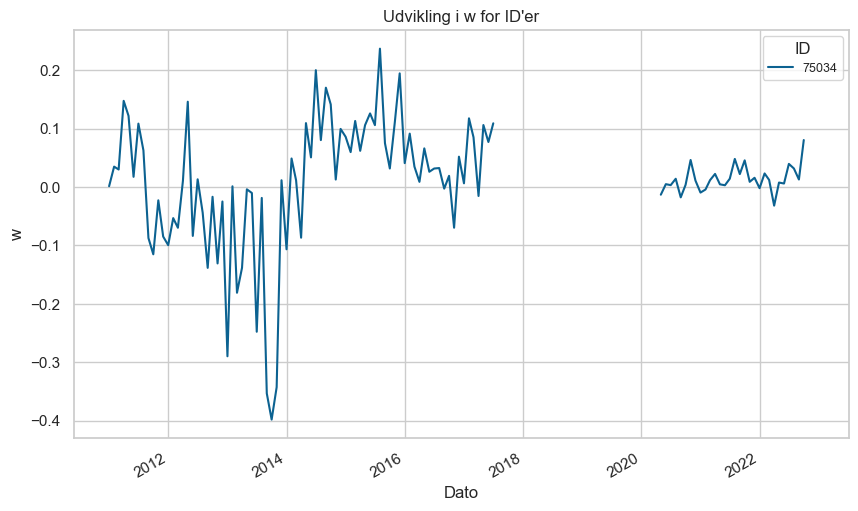

In [77]:
#Check af id som forsvinder: 75034 "denne fjernes i midt 2017, så den burde ikke være med eller i det mindste være lig 0 
my_ids2 = [75034]
plot_specific_ids(tpf_trans["w"], my_ids2, weight_col='w') 
plot_specific_ids(tpf_original["w"], my_ids2, weight_col='w') 

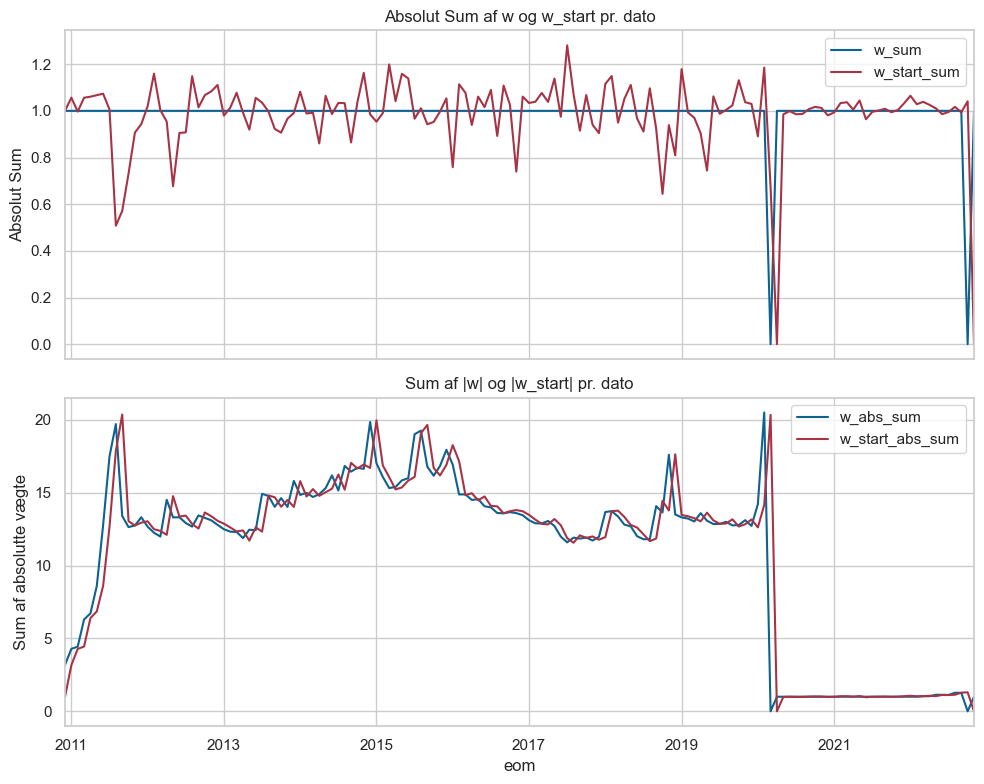

In [78]:
df = tpf_trans["w"].copy()

# 1) Gruppér pr. dato (eom) og beregn sum af w, sum af w_start,
#    samt sum af |w| og sum af |w_start|
df_agg = df.groupby("eom").agg({
    "w": ["sum", lambda x: x.abs().sum()],
    "w_start": ["sum", lambda x: x.abs().sum()]
})

# 2) Giv kolonnerne mere sigende navne
df_agg.columns = ["w_sum", "w_abs_sum", "w_start_sum", "w_start_abs_sum"]

# 3) Plot
fig, ax = plt.subplots(2, 1, figsize=(10, 8), sharex=True)

# Plot sum(w) og sum(w_start) i øverste subplot
df_agg[["w_sum", "w_start_sum"]].plot(ax=ax[0])
ax[0].set_title("Absolut Sum af w og w_start pr. dato")
ax[0].set_ylabel("Absolut Sum")

# Plot sum(|w|) og sum(|w_start|) i nederste subplot
df_agg[["w_abs_sum", "w_start_abs_sum"]].plot(ax=ax[1])
ax[1].set_title("Sum af |w| og |w_start| pr. dato")
ax[1].set_ylabel("Sum af absolutte vægte")

plt.tight_layout()
plt.show()


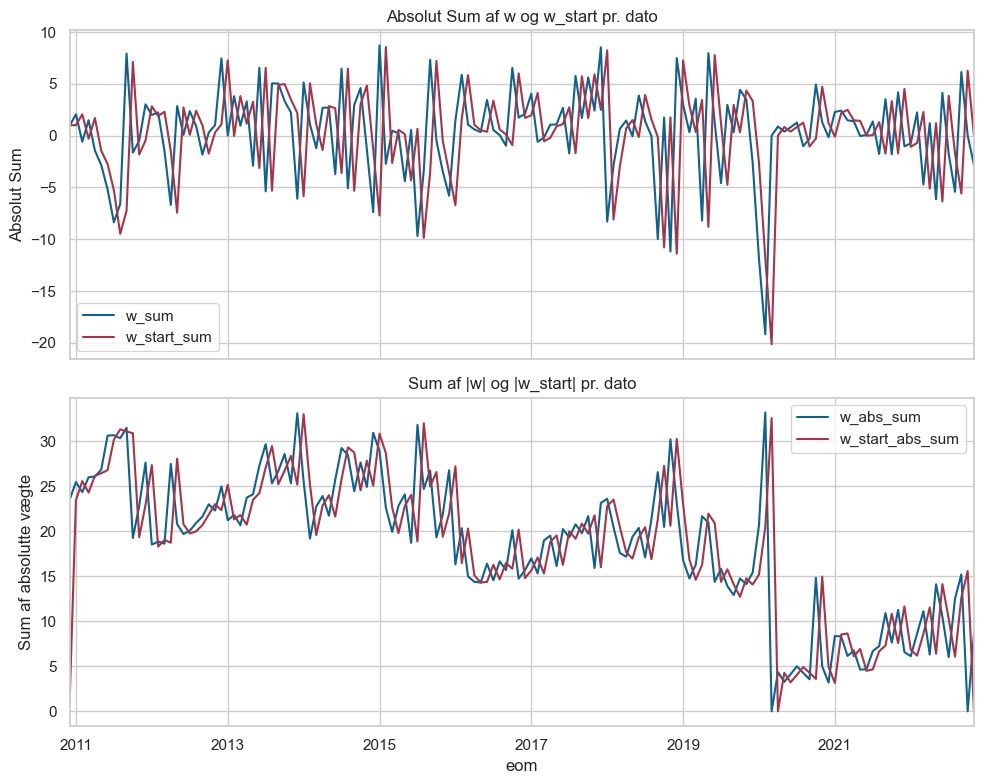

In [79]:
df = tpf_original["w"].copy()

# 1) Gruppér pr. dato (eom) og beregn sum af w, sum af w_start,
#    samt sum af |w| og sum af |w_start|
df_agg = df.groupby("eom").agg({
    "w": ["sum", lambda x: x.abs().sum()],
    "w_start": ["sum", lambda x: x.abs().sum()]
})

# 2) Giv kolonnerne mere sigende navne
df_agg.columns = ["w_sum", "w_abs_sum", "w_start_sum", "w_start_abs_sum"]

# 3) Plot
fig, ax = plt.subplots(2, 1, figsize=(10, 8), sharex=True)

# Plot sum(w) og sum(w_start) i øverste subplot
df_agg[["w_sum", "w_start_sum"]].plot(ax=ax[0])
ax[0].set_title("Absolut Sum af w og w_start pr. dato")
ax[0].set_ylabel("Absolut Sum")

# Plot sum(|w|) og sum(|w_start|) i nederste subplot
df_agg[["w_abs_sum", "w_start_abs_sum"]].plot(ax=ax[1])
ax[1].set_title("Sum af |w| og |w_start| pr. dato")
ax[1].set_ylabel("Sum af absolutte vægte")

plt.tight_layout()
plt.show()


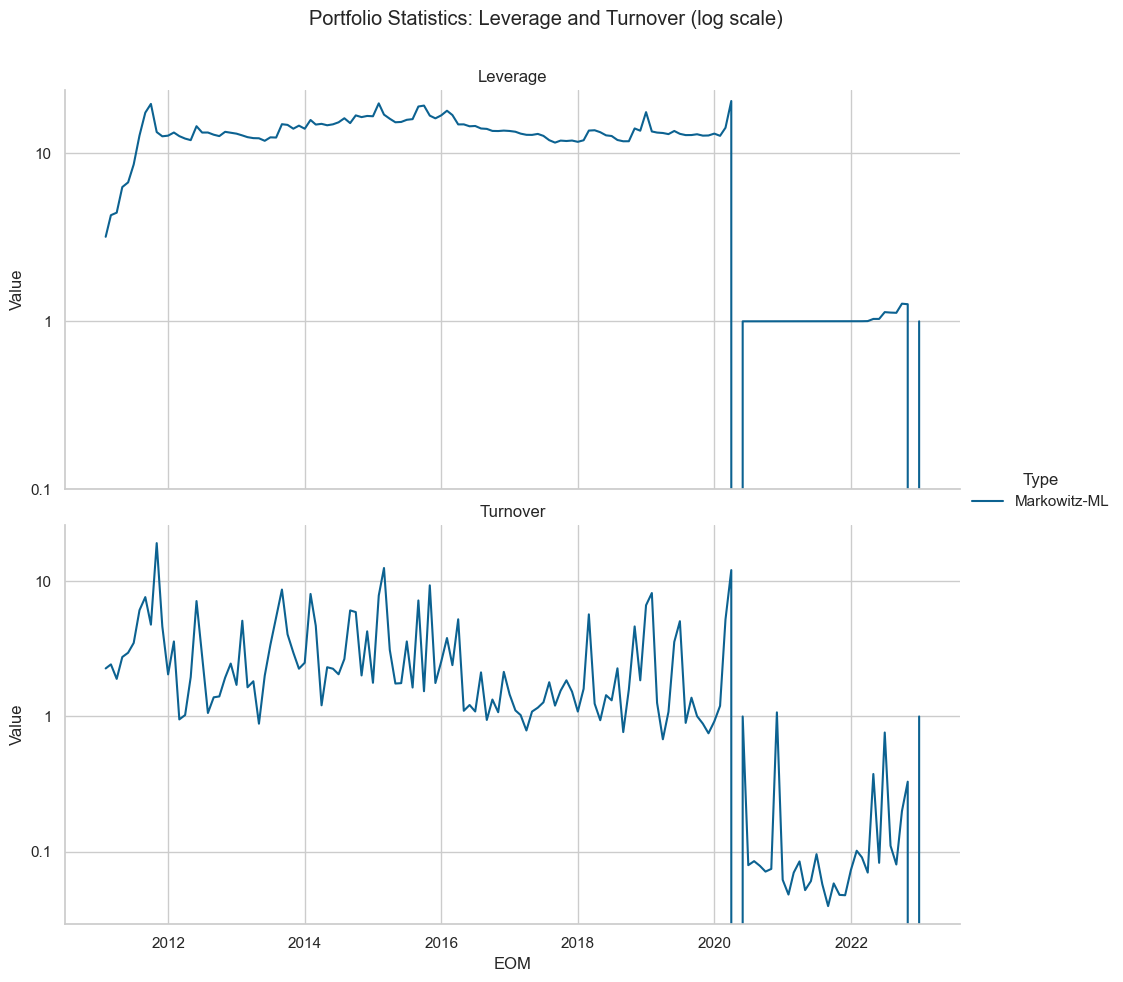

In [80]:
# 1. Kopier data for Markowitz-ML
tpf_pf = tpf_trans['pf'].copy()

# 2. Sæt type-kolonnen til "Markowitz-ML"
tpf_pf["type"] = "Markowitz-ML"

# 3. Vælg de relevante kolonner: eom_ret, inv og turnover (samt type)
ws = tpf_pf[['eom_ret', 'inv', 'turnover', 'type']].copy()

# 4. Omdøb eom_ret til eom for korthed
ws.rename(columns={'eom_ret': 'eom'}, inplace=True)

# 5. Konverter til long format, så vi kan plotte Leverage og Turnover i separate paneler
ws_long = ws.melt(
    id_vars=['type', 'eom'],
    value_vars=['inv', 'turnover'],
    var_name='metric',
    value_name='value'
)

# 6. Omdøb metric-værdier til pænere navne
ws_long['metric'] = ws_long['metric'].map({
    'inv': 'Leverage',
    'turnover': 'Turnover'
})

# 7. Plot med Seaborn's FacetGrid
g = sns.FacetGrid(ws_long, col="metric", col_wrap=1, sharey=False, height=5, aspect=2)
g.map_dataframe(sns.lineplot, x="eom", y="value", hue="type", style="type")

# Sæt y-aksen til log-skala
g.set(yscale="log")

# Fjern "metric = " i facettitlen
g.set_titles("{col_name}")

# Tilføj en fælles legend
g.add_legend(title="Type")

# Angiv egne ticks på y-aksen
for ax in g.axes.flatten():
    ax.set_yticks([0.1, 1, 10])
    ax.set_yticklabels(['0.1', '1', '10'])

# Sæt akse-labels og en overordnet titel
g.set_axis_labels("EOM", "Value")
plt.subplots_adjust(top=0.9)
g.fig.suptitle("Portfolio Statistics: Leverage and Turnover (log scale)")

plt.show()


In [81]:
print(tpf_trans['w'][tpf_trans['w']["id"] == 75034])

          id        eom     w_start           w      tr_ld1      mu_ld1
101    75034 2010-12-31  0.00305899  0.00446958         NaN         NaN
281    75034 2011-01-31  0.00525101 -0.00015011  0.19838985  0.02005247
461    75034 2011-02-28 -0.00015017  0.00020235  0.03924235  0.03882076
641    75034 2011-03-31  0.00020843 -0.00184087  0.03353050  0.00338251
821    75034 2011-04-30 -0.00188850  0.00323933  0.05424833  0.02766186
...      ...        ...         ...         ...         ...         ...
25068  75034 2022-07-31  0.00378320  0.00469528 -0.11036095  0.09363012
25247  75034 2022-08-31  0.00481880  0.00485779 -0.01083242 -0.03618817
25426  75034 2022-09-30  0.00443602  0.00487344 -0.17025866 -0.09136964
25605  75034 2022-10-31  0.00594551         NaN  0.31922955  0.08135025
25785  75034 2022-11-30  0.00000000  0.00555556         NaN         NaN

[112 rows x 6 columns]


In [82]:
with pd.option_context('display.max_rows', None):
    print(tpf_trans['w'][tpf_trans['w']["id"] == 10107])


          id        eom     w_start           w      tr_ld1      mu_ld1
1      10107 2010-12-31  0.02909715  0.02921283         NaN         NaN
181    10107 2011-01-31  0.02844970  0.02249994 -0.00659443  0.02005247
361    10107 2011-02-28  0.02088915  0.02177787 -0.03554952  0.03882076
541    10107 2011-03-31  0.02073345  0.01958657 -0.04473752  0.00338251
721    10107 2011-04-30  0.01945810  0.02433854  0.02092139  0.02766186
901    10107 2011-05-31  0.02399562  0.03356142 -0.02894818 -0.01507072
1081   10107 2011-06-30  0.03555924  0.05300790  0.03954916 -0.01885551
1261   10107 2011-07-31  0.05725323  0.02356124  0.05387414 -0.02427067
1441   10107 2011-08-31  0.02448299  0.03722916 -0.02344064 -0.06020673
1621   10107 2011-09-30  0.03807908 -0.02129396 -0.06418475 -0.08507211
1801   10107 2011-10-31 -0.02041416 -0.00798926  0.06989358  0.11600331
1981   10107 2011-11-30 -0.00777584 -0.00602220 -0.03192286 -0.00535172
2161   10107 2011-12-31 -0.00609437  0.08613790  0.01485532  0.0

In [83]:
with pd.option_context('display.max_rows', None):
    print(tpf_original['w'][tpf_original['w']["id"] == 10107]) #75034

        id        eom     w_start           w      tr_ld1      mu_ld1
144  10107 2010-12-31  0.02909715 -0.00940797         NaN         NaN
145  10107 2011-01-31 -0.00916221 -0.20988654 -0.00659443  0.02005247
146  10107 2011-02-28 -0.19486054 -0.17651783 -0.03554952  0.03882076
147  10107 2011-03-31 -0.16805242 -0.01945283 -0.04473752  0.00338251
148  10107 2011-04-30 -0.01932523 -0.07447338  0.02092139  0.02766186
149  10107 2011-05-31 -0.07342406 -0.07867773 -0.02894818 -0.01507072
150  10107 2011-06-30 -0.08336118  0.30212174  0.03954916 -0.01885551
151  10107 2011-07-31  0.32631825 -0.27643876  0.05387414 -0.02427067
152  10107 2011-08-31 -0.28725345 -0.05089503 -0.02344064 -0.06020673
153  10107 2011-09-30 -0.05205693  0.01842412 -0.06418475 -0.08507211
154  10107 2011-10-31  0.01766290  0.17549969  0.06989358  0.11600331
155  10107 2011-11-30  0.17081137  0.12140953 -0.03192286 -0.00535172
156  10107 2011-12-31  0.12286440  0.38613790  0.01485532  0.00283817
157  10107 2012-01-3

In [84]:
#w_opt['w'] * (1 + w_opt['tr_ld1']) / (1 + w_opt['mu_ld1'])
#print(-(0.004710)* (1 + 0.039242) / (1 + 0.038821))

In [85]:
w_start_eks = 0.012686
w_eks = 0.009032
d_eks = pd.Timestamp('2011-01-31')
wealth_eks = wealth.loc[wealth['eom'] == d_eks, 'wealth'].iloc[0]
lambda_eks = lambda_list['2011-01-31'][10104]
tc_eks = (wealth_eks / 2) * np.sum(lambda_eks * ((w_eks - w_start_eks) ** 2))
print("wealth:",wealth_eks)
print("lambda:",lambda_eks)
print("tc:",tc_eks)

wealth: 2241751489.312403
lambda: 2.2003935425770323e-10
tc: 3.2930241757205893e-06


# Markowitz-ML med gearing begrænsninger så kun long only

In [86]:
def tpf_implement_long_only(data, cov_list, wealth, dates, gam):
    """
    Beregner tangency portfolio weights og porteføljestatistikker med constraints:
      - Ingen shorting: w >= 0
      - Summering til 1: sum(w) == 1

    Parametre:
      - data: DataFrame med kolonnerne 'id', 'eom', 'me', 'tr_ld1', 'pred_ld1' og 'valid'
      - cov_list: dictionary med nøgler som datoer (som strings, fx '2019-12-31') og værdier,
                  hvor hvert element er en dictionary med nøglerne 'fct_load', 'fct_cov' og 'ivol_vec'
      - wealth: DataFrame med kolonnerne 'eom', 'mu_ld1' og 'wealth'
      - dates: liste over datoer (som pd.Timestamp eller strings)
      - gam: risikoaversion parameter

    Returnerer:
      - en dictionary med nøglerne "w" (de faktiske vægte) og "pf" (porteføljestatistikker)
    """
    # Filtrer data for gyldige rækker med eom i dates
    data_rel = data[(data['valid'] == True) & (data['eom'].isin(dates))][['id', 'eom', 'me', 'tr_ld1', 'pred_ld1']]
    data_rel = data_rel.sort_values(by=['id', 'eom'])
    
    # Opdel data_rel i grupper pr. eom
    data_split = {d: df for d, df in data_rel.groupby('eom')}
    tpf_opt_list = []

    for d in dates:
        # Konverter d til string, hvis d er en pd.Timestamp (cov_list-nøglerne forventes som strings)
        if isinstance(d, pd.Timestamp):
            d_key = d.strftime('%Y-%m-%d')
        else:
            d_key = d

        data_sub = data_split.get(d)
        if data_sub is None or data_sub.empty:
            continue

        ids = data_sub['id'].tolist()

        # Brug standalone funktionen create_cov her
        sigma = General_Functions.create_cov(cov_list[d_key], ids=ids)

        # Hent prediktioner for den aktuelle dato
        pred_vector = data_sub['pred_ld1'].values
        n = len(pred_vector)
        
        # Optimer med CVXPY: maksimer pred_vector' * w - 0.5*gam * w' * sigma * w
        # under constraints: sum(w) == 1 og w >= 0
        w_var = cp.Variable(n)
        objective = cp.Maximize(pred_vector.T @ w_var - 0.5 * gam * cp.quad_form(w_var, sigma))
        constraints = [cp.sum(w_var) == 1, w_var >= 0]
        prob = cp.Problem(objective, constraints)
        prob.solve(solver=cp.OSQP)

        if w_var.value is None:
            raise ValueError(f"Optimeringsproblemet for dato {d} kunne ikke løses.")
        weights = w_var.value

        temp_df = data_sub[['id', 'eom']].copy()
        temp_df['w'] = weights
        tpf_opt_list.append(temp_df)

    if tpf_opt_list:
        tpf_opt = pd.concat(tpf_opt_list, ignore_index=True)
    else:
        tpf_opt = pd.DataFrame(columns=['id', 'eom', 'w'])

    # Beregn de faktiske vægte vha. w_fun (forventes defineret et andet sted)
    tpf_w = portfolio_choice_functions.w_fun(data_rel, dates, tpf_opt, wealth)
    # Beregn porteføljestatistikker vha. pf_ts_fun (forventes defineret et andet sted)
    tpf_pf = General_Functions.pf_ts_fun(tpf_w, data, wealth, gam)
    tpf_pf['type'] = "Markowitz-ML-no-shorting"

    return {"w": tpf_w, "pf": tpf_pf}


In [87]:
tpf_longonly = tpf_implement_long_only(data=chars, cov_list=barra_cov, wealth=wealth, dates=dates_oos, gam=pf_set["gamma_rel"])

In [88]:
tpf_longonly['w']

id        eom     w_start           w      tr_ld1      mu_ld1
0      10104 2010-12-31  0.01962004 -0.00000000         NaN         NaN
1      10104 2011-01-31 -0.00000000  0.00000000  0.02495411  0.02005247
2      10104 2011-02-28  0.00000000 -0.00000000  0.02714012  0.03882076
3      10104 2011-03-31 -0.00000000  0.00000000  0.01621833  0.00338251
4      10104 2011-04-30  0.00000000 -0.00000000  0.07744176  0.02766186
...      ...        ...         ...         ...         ...         ...
25859  92655 2022-07-31 -0.00000000 -0.00000000  0.05568431  0.09363012
25860  92655 2022-08-31 -0.00000000 -0.00000000 -0.04352827 -0.03618817
25861  92655 2022-09-30 -0.00000000 -0.00000000 -0.02436807 -0.09136964
25862  92655 2022-10-31 -0.00000000         NaN  0.09879290  0.08135025
25863  92655 2022-11-30  0.00000000  0.00000000 -0.01386774  0.05132895

[25864 rows x 6 columns]

# Markowitz-ML med transactions cost optimering og gearing begrænsninger på de optimale vægte (så kun long-only pf)

In [89]:

def tpf_implement_qp(data, cov_list, wealth, dates, gam, delta, alpha):
    """
    Beregner porteføljens vægte dato-for-dato med:
      - En long-only Markowitz-ML-model til at finde w_opt (non-shorting),
      - En QP, der sikrer, at w_final ligger inden for ±delta af w_opt,
      - Og som minimerer en kombineret objektfunktion:
            alpha * ||w - w_opt||^2 + (1 - alpha)* sum(lam * (w - w_start)^2)
        hvor w_start er den afkastjusterede vægt fra forrige periode.
    
    Parametre:
      - data: DataFrame med aktiedata
      - cov_list: dictionary med kovariansmatricer (nøgle: dato, som string)
      - wealth: DataFrame med wealth og mu_ld1 for hver dato
      - dates: liste over datoer (som pd.Timestamp eller strings)
      - gam: risikoaversion parameter
      - delta: maks. afvigelse fra w_opt (f.eks. 0.2)
      - alpha: vægtning mellem at holde sig tæt på w_opt og minimere transaktionsomkostninger
      
    Returnerer:
      - tpf_opt: DataFrame med kolonnerne ['id', 'eom', 'w'] for hver dato.
    """
    # Filtrer og sorter data
    data_rel = data[(data['valid'] == True) & (data['eom'].isin(dates))][['id', 'eom', 'me', 'tr_ld1', 'pred_ld1']]
    data_rel = data_rel.sort_values(by=['id', 'eom'])
    data_split = {d: df for d, df in data_rel.groupby('eom')}
    
    # Helper-funktion til afkastjustering af w_prev (fra forrige periode)
    def adjust_w_prev_for_returns(w_prev_series, df_current, wealth_current):
        df_current = df_current.set_index('id')
        w_prev_aligned = w_prev_series.reindex(df_current.index).fillna(0)
        tr_ld1 = df_current['tr_ld1']
        mu_ld1 = wealth_current['mu_ld1'].iloc[0]  # antager én værdi pr. dato
        return w_prev_aligned * (1 + tr_ld1) / (1 + mu_ld1)

    tpf_opt_list = []
    
    # For den første dato: brug initiale VW-vægte
    first_date = dates[0]
    data_first = data_split[first_date]
    init_w = General_Functions.initial_weights_new(data_first, w_type="vw")
    # Gem som Series med id som index
    w_prev_final = pd.Series(init_w['w_start'].values, index=init_w['id'])

    for d in dates:
        # Lav nøglen til cov_list
        d_key = d.strftime('%Y-%m-%d') if isinstance(d, pd.Timestamp) else d
        data_sub = data_split.get(d)
        if data_sub is None or data_sub.empty:
            continue

        ids = data_sub['id'].tolist()
        sigma = General_Functions.create_cov(cov_list[d_key], ids=ids)
        pred_vector = data_sub['pred_ld1'].values
        n = len(pred_vector)
        
        # 1) Beregn long-only w_opt ved at løse:
        #    max  pred_vector' * w - 0.5*gam*w' Sigma w
        #    s.t. sum(w)=1, w >= 0
        w_var = cp.Variable(n)
        objective = cp.Maximize(pred_vector.T @ w_var - 0.5 * gam * cp.quad_form(w_var, sigma))
        constraints_long = [cp.sum(w_var) == 1, w_var >= 0]
        prob_long = cp.Problem(objective, constraints_long)
        prob_long.solve(solver=cp.OSQP)
        if w_var.value is None:
            raise ValueError(f"Long-only Markowitz-problem for dato {d} kunne ikke løses.")
        w_opt = w_var.value
        
        # 2) Juster forrige periodes vægte (w_prev_final) for afkast
        wealth_d = wealth.loc[wealth['eom'] == d]
        w_start = adjust_w_prev_for_returns(w_prev_final, data_sub, wealth_d)
        
        # 3) Løs QP for transaktionsomkostninger med de nye constraints (long-only: w >= 0)
        #    min  alpha*||w - w_opt||^2 + (1-alpha)* sum(lam*(w - w_start)^2)
        #    s.t. w_i in [w_opt_i - delta, w_opt_i + delta], sum(w)=1, w >= 0
        lam = data_sub['lambda'].values if 'lambda' in data_sub.columns else np.ones_like(w_opt)
        w = cp.Variable(n)
        obj = alpha * cp.sum_squares(w - w_opt) + (1 - alpha) * cp.sum(cp.multiply(lam, cp.square(w - w_start)))
        constraints = [
            w >= w_opt - delta,
            w <= w_opt + delta,
            cp.sum(w) == 1,
            w >= 0
        ]
        prob = cp.Problem(cp.Minimize(obj), constraints)
        prob.solve(solver=cp.OSQP)
        if w.value is None:
            raise ValueError(f"Optimeringsproblemet for dato {d} kunne ikke løses.")
        w_final = w.value
        
        # 4) Gem resultater for denne dato
        temp_df = data_sub[['id', 'eom']].copy()
        temp_df['w'] = w_final
        tpf_opt_list.append(temp_df)
        
        # 5) Opdater w_prev_final til næste periode
        w_prev_final = pd.Series(w_final, index=data_sub['id'])
    
    if tpf_opt_list:
        tpf_opt = pd.concat(tpf_opt_list, ignore_index=True)
    else:
        tpf_opt = pd.DataFrame(columns=['id','eom','w'])
    
    # Ekstra efterbehandling, hvis nødvendigt (f.eks. via w_fun_post)
    tpf_w = w_fun_post(tpf_opt, data, wealth)
    return tpf_opt  # Eller returnér en dict med "w" og "pf"

def w_fun_post(tpf_opt, data, wealth):
    """ Enkel version af w_fun - returnerer blot tpf_opt. """
    return tpf_opt


In [90]:
tpf_longonly_trans = run_markowitz_qp_pipeline(
    data=chars, 
    cov_list=barra_cov, 
    wealth=wealth, 
    dates=dates_oos, 
    gam=pf_set["gamma_rel"],
    delta=0.15,
    alpha=0
)


In [91]:
tpf_longonly_trans['w']

id        eom    w_start          w  tr_ld1  mu_ld1
0      10104 2010-12-31 0.01962004 0.01904129     NaN     NaN
1      10107 2010-12-31 0.02909715 0.02766400     NaN     NaN
2      10138 2010-12-31 0.00207196 0.00140170     NaN     NaN
3      10696 2010-12-31 0.00106728 0.00043065     NaN     NaN
4      11308 2010-12-31 0.01894753 0.01707797     NaN     NaN
...      ...        ...        ...        ...     ...     ...
25859  87299 2022-11-30 0.00000000 0.00555556     NaN     NaN
25860  87432 2022-11-30 0.00000000 0.00555556     NaN     NaN
25861  87447 2022-11-30 0.00000000 0.00555556     NaN     NaN
25862  87717 2022-11-30 0.00000000 0.00555556     NaN     NaN
25863  92655 2022-11-30 0.00000000 0.00555556     NaN     NaN

[25864 rows x 6 columns]

# Relevante plots og stats for No gearing MVO vs trade cost no gearing optimeret MVO

In [92]:
df_metrics = compare_portfolio_metrics(tpf_longonly, tpf_longonly_trans)
display(df_metrics)
latex_table = df_metrics.to_latex(index=False, float_format="%.4f", caption="Sammenligning af porteføljemålepunkter", label="tab:portfolio_metrics")
print(latex_table)
latex_table = df_metrics.set_index("Metric").T.to_latex(
    float_format="%.4f",
    caption="Sammenligning af porteføljemålepunkter (transponeret)",
    label="tab:portfolio_metrics_transposed"
)
print(latex_table)

Metric  Markowitz-ML  Markowitz-ML TC optimeret
0         r_yearly    0.13883855                 0.15665623
1       std_yearly    0.13480424                 0.13157603
2  SR_gross_yearly    1.02992719                 1.19061378
3        tc_yearly    6.26300974                 0.14128313
4      r_tc_yearly   -6.12417119                 0.01537310
5    SR_net_yearly  -45.43010956                 0.11683819
6              inv    0.98611111                 0.98613635
7         Shorting    0.00000000                 0.00001262
8         Turnover    1.07032722                 0.11562952

\begin{table}
\caption{Sammenligning af porteføljemålepunkter}
\label{tab:portfolio_metrics}
\begin{tabular}{lrr}
\toprule
Metric & Markowitz-ML & Markowitz-ML TC optimeret \\
\midrule
r_yearly & 0.1388 & 0.1567 \\
std_yearly & 0.1348 & 0.1316 \\
SR_gross_yearly & 1.0299 & 1.1906 \\
tc_yearly & 6.2630 & 0.1413 \\
r_tc_yearly & -6.1242 & 0.0154 \\
SR_net_yearly & -45.4301 & 0.1168 \\
inv & 0.9861 & 0.9861 \\
Shorting & 0.0000 & 0.0000 \\
Turnover & 1.0703 & 0.1156 \\
\bottomrule
\end{tabular}
\end{table}

\begin{table}
\caption{Sammenligning af porteføljemålepunkter (transponeret)}
\label{tab:portfolio_metrics_transposed}
\begin{tabular}{lrrrrrrrrr}
\toprule
Metric & r_yearly & std_yearly & SR_gross_yearly & tc_yearly & r_tc_yearly & SR_net_yearly & inv & Shorting & Turnover \\
\midrule
Markowitz-ML & 0.1388 & 0.1348 & 1.0299 & 6.2630 & -6.1242 & -45.4301 & 0.9861 & 0.0000 & 1.0703 \\
Markowitz-ML TC optimeret & 0.1567 & 0.1316 & 1.1906 & 0.1413 & 0.0154 & 0.1168 & 0.9861 & 0.0000 & 0.1

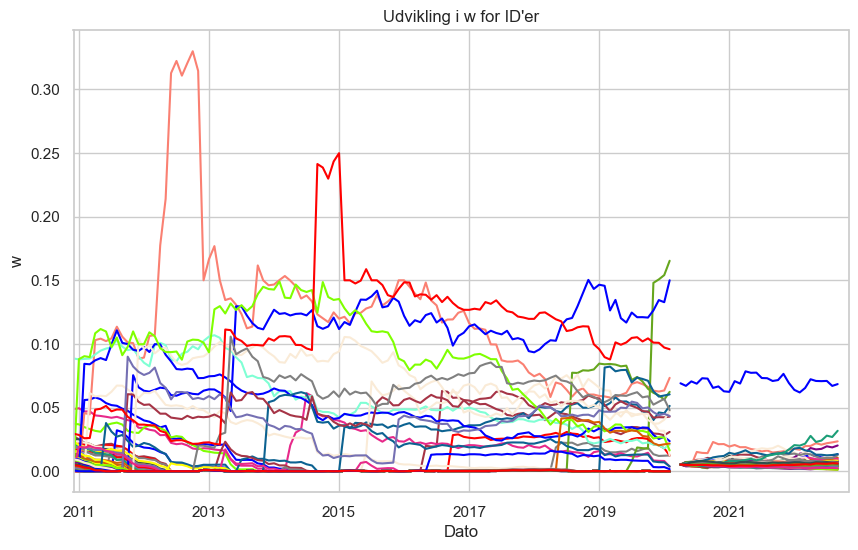

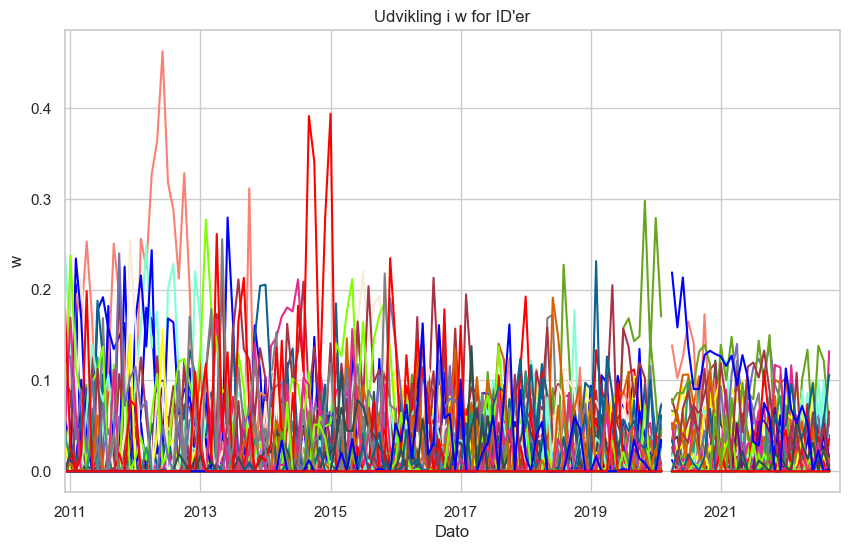

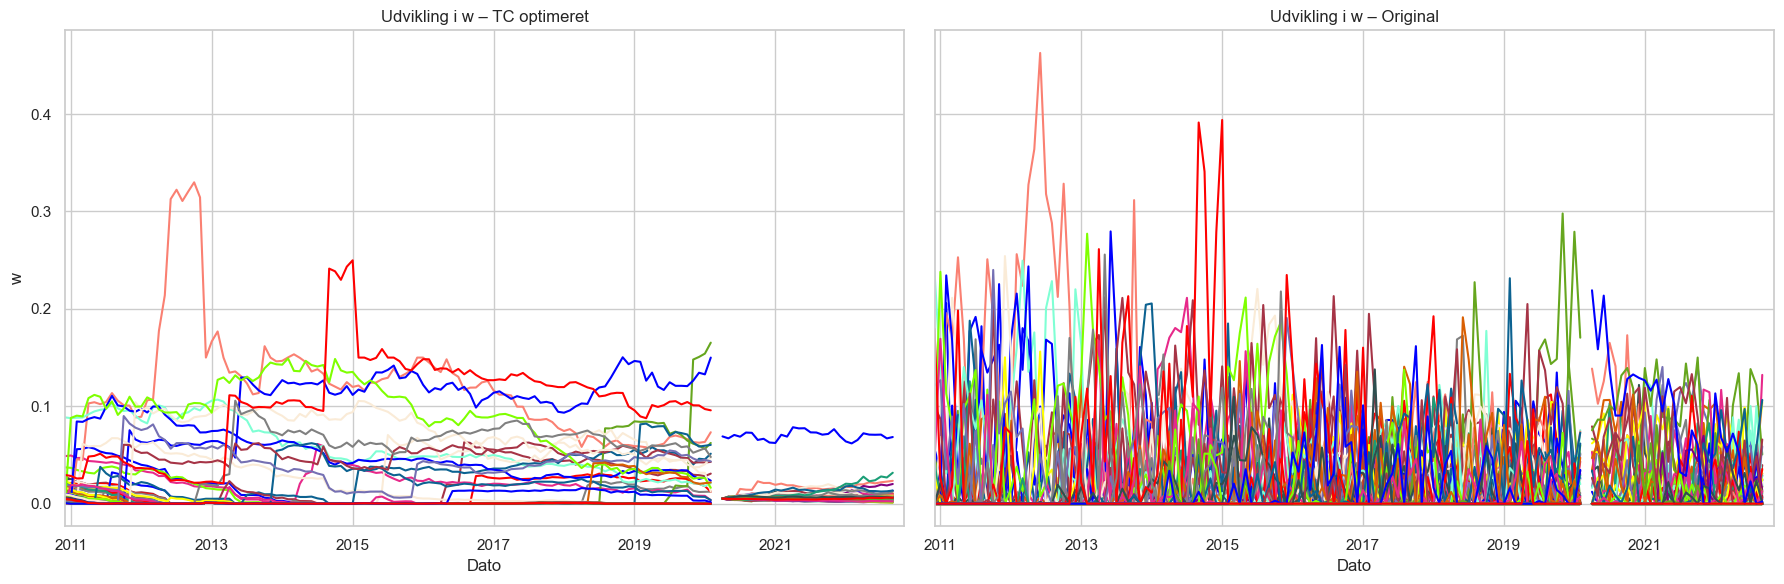

In [93]:
plot_specific_ids(tpf_longonly_trans["w"], id_list=None, weight_col='w', show_legend=False)
plot_specific_ids(tpf_longonly["w"], id_list=None, weight_col='w', show_legend=False)

fig, axes = plt.subplots(1, 2, figsize=(18, 6), sharey=True)

# Plot tpf_trans (optimeret)
plot_specific_ids(tpf_longonly_trans["w"], id_list=None, weight_col="w", ax=axes[0], show_legend=False)
axes[0].set_title("Udvikling i w – TC optimeret")
axes[0].set_xlabel("Dato")
axes[0].set_ylabel("w")

# Plot tpf_original
plot_specific_ids(tpf_longonly["w"], id_list=None, weight_col="w", ax=axes[1], show_legend=False)
axes[1].set_title("Udvikling i w – Original")
axes[1].set_xlabel("Dato")

plt.tight_layout()
plt.savefig(os.path.join(output_folder, "w_udvikling_trans_gearing_opt"), dpi=300, bbox_inches='tight')
plt.show()


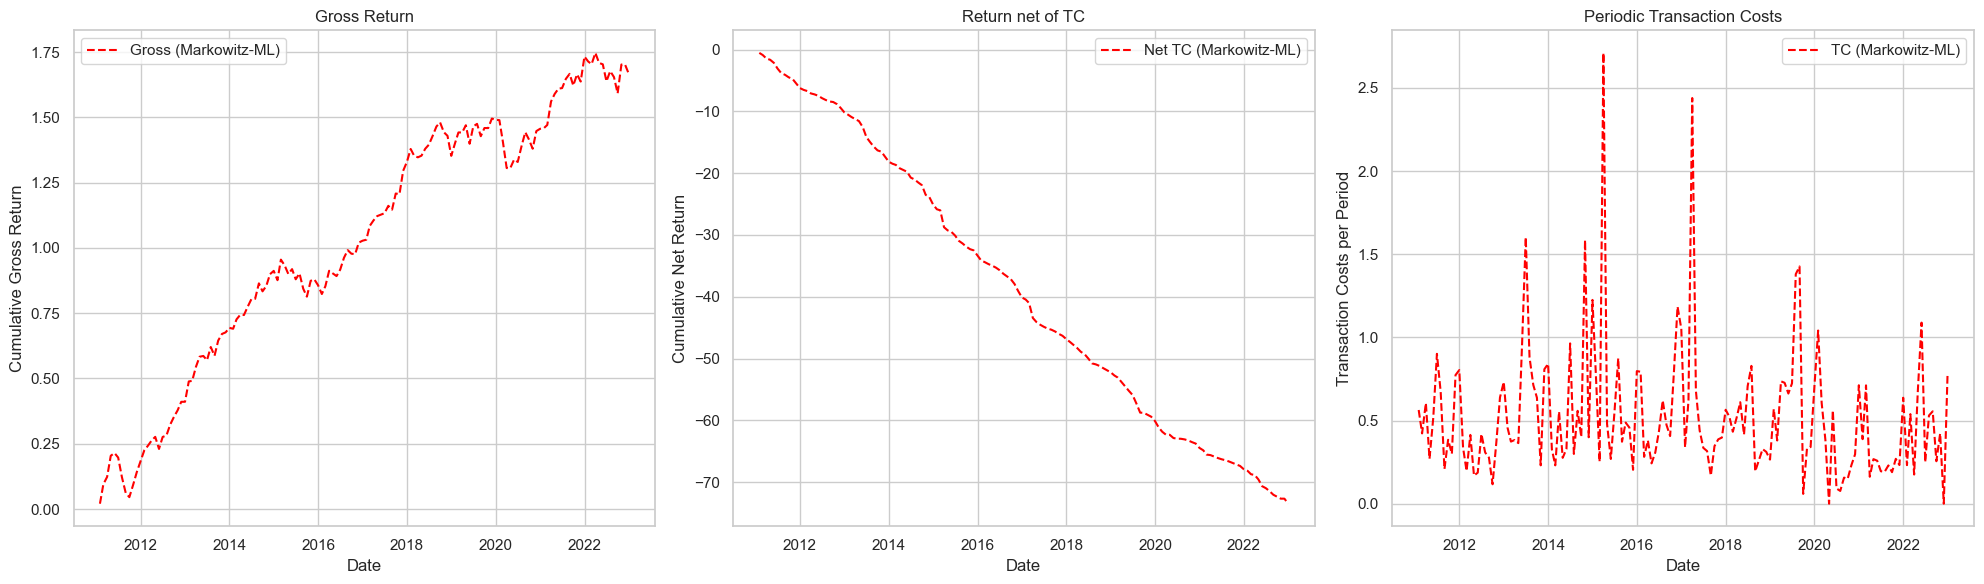

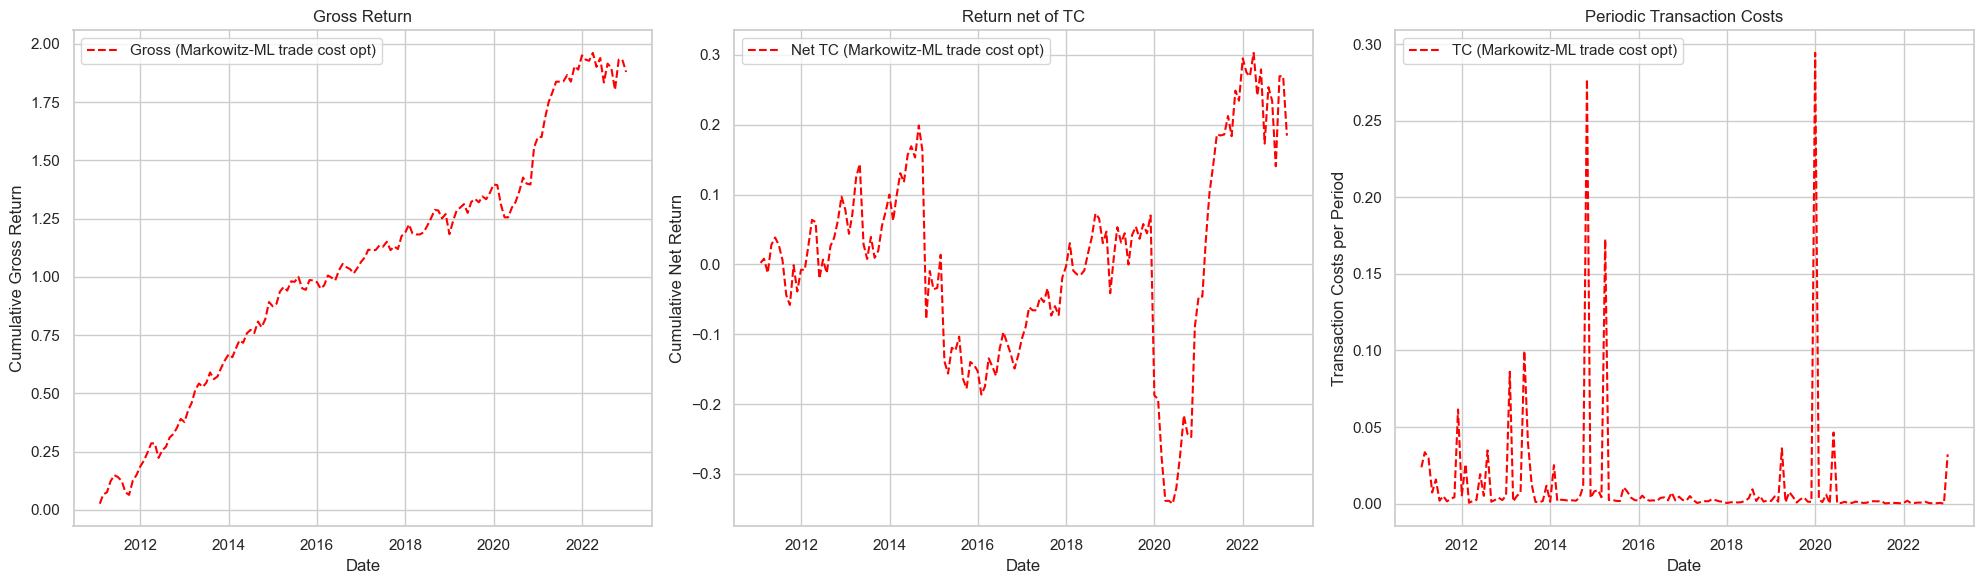

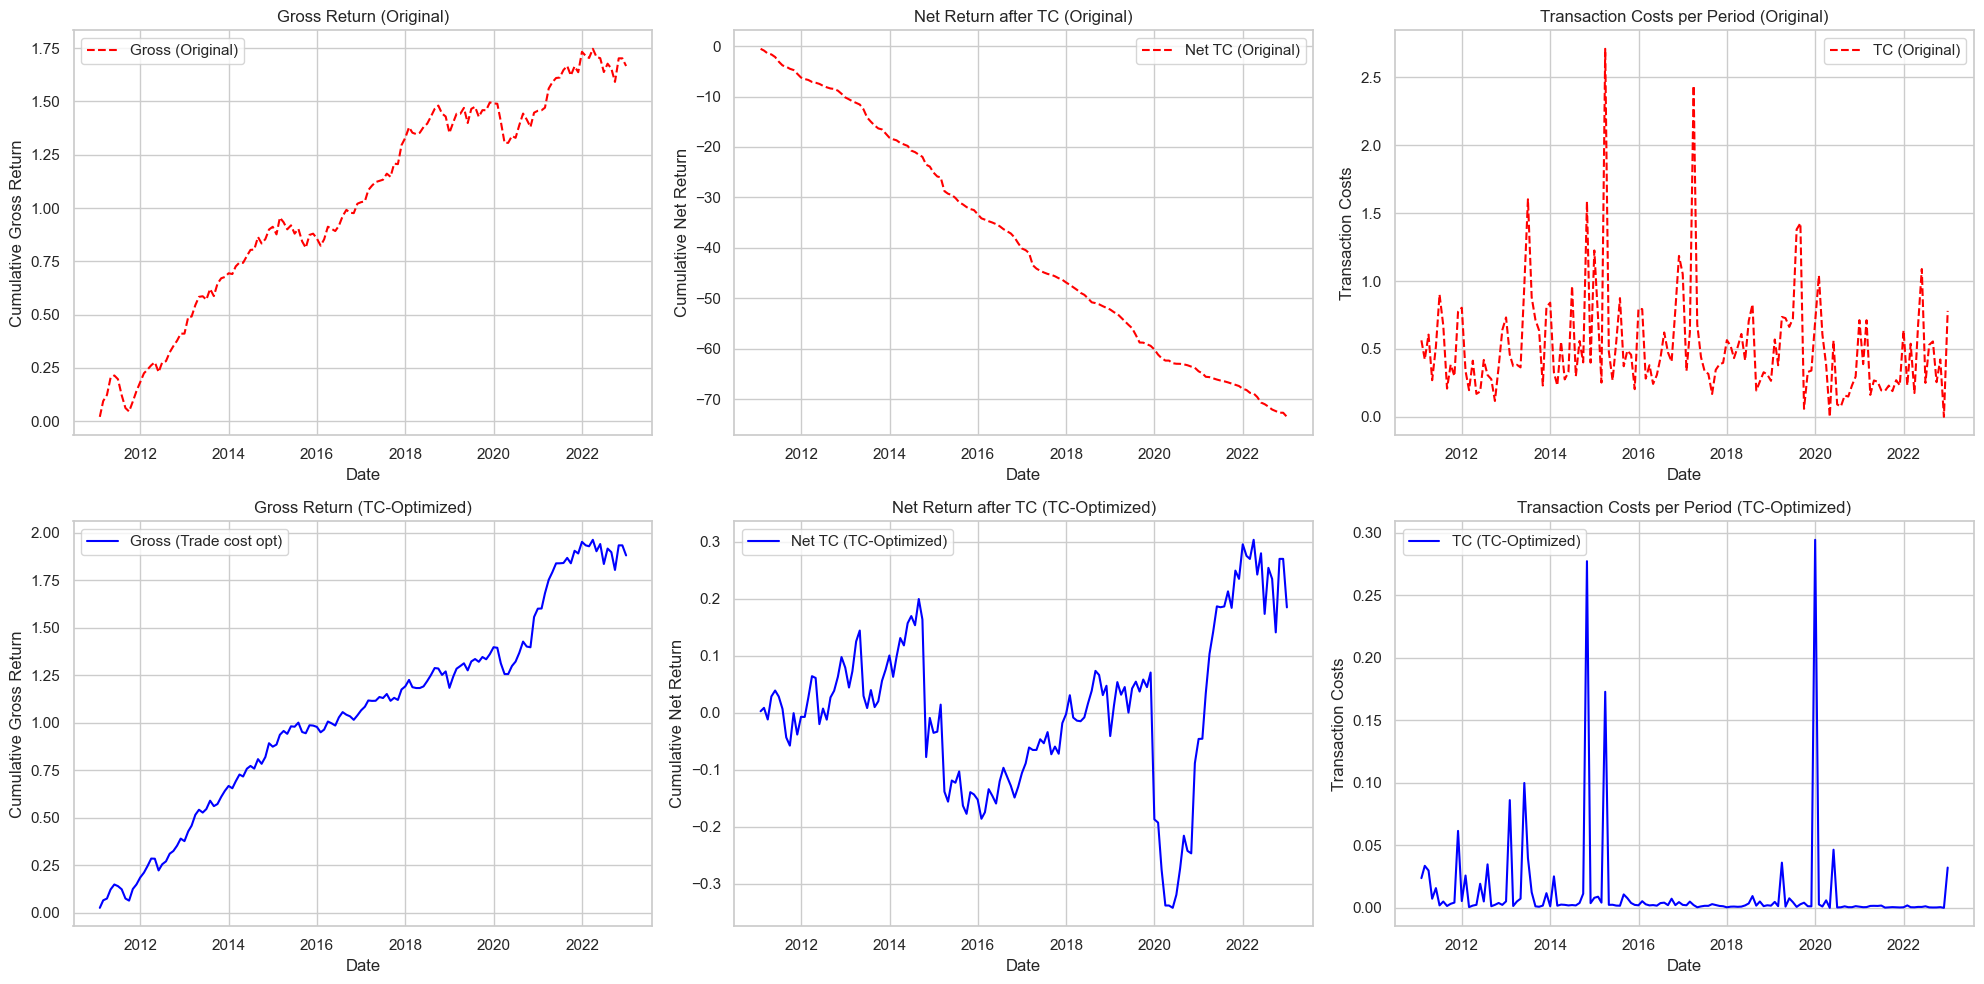

In [94]:
# Kopier dataframe for Markowitz-ML
tpf_data = tpf_longonly["pf"].copy()

# Beregn kumulative afkast for Markowitz-ML
tpf_data['cumret'] = tpf_data['r'].cumsum()
tpf_data['cumret_tc'] = (tpf_data['r'] - tpf_data['tc']).cumsum()

tpf_data_new = tpf_longonly_trans["pf"].copy()

# Beregn kumulative afkast for Markowitz-ML
tpf_data_new['cumret'] = tpf_data_new['r'].cumsum()
tpf_data_new['cumret_tc'] = (tpf_data_new['r'] - tpf_data_new['tc']).cumsum()

# Opret 3 subplots: Gross Return, Return net of TC og Periodiske Transaction Costs
fig, axes = plt.subplots(1, 3, figsize=(20, 6))

# --- Plot 1: Gross Return ---
ax = axes[0]
ax.plot(tpf_data['eom_ret'], tpf_data['cumret'], label='Gross (Markowitz-ML)', color='red', linestyle='--')
ax.set_xlabel('Date')
ax.set_ylabel('Cumulative Gross Return')
ax.set_title('Gross Return')
ax.grid(True)
ax.legend()

# --- Plot 2: Return net of TC ---
ax = axes[1]
ax.plot(tpf_data['eom_ret'], tpf_data['cumret_tc'], label='Net TC (Markowitz-ML)', color='red', linestyle='--')
ax.set_xlabel('Date')
ax.set_ylabel('Cumulative Net Return')
ax.set_title('Return net of TC')
ax.grid(True)
ax.legend()

# --- Plot 3: Periodiske Transaction Costs ---
ax = axes[2]
ax.plot(tpf_data['eom_ret'], tpf_data['tc'], label='TC (Markowitz-ML)', color='red', linestyle='--')
ax.set_xlabel('Date')
ax.set_ylabel('Transaction Costs per Period')
ax.set_title('Periodic Transaction Costs')
ax.grid(True)
ax.legend()

plt.tight_layout()
plt.show()

# Opret 3 subplots: Gross Return, Return net of TC og Periodiske Transaction Costs
fig, axes = plt.subplots(1, 3, figsize=(20, 6))
# --- Plot 1: Gross Return ---
ax = axes[0]
ax.plot(tpf_data['eom_ret'], tpf_data_new['cumret'], label='Gross (Markowitz-ML trade cost opt)', color='red', linestyle='--')
ax.set_xlabel('Date')
ax.set_ylabel('Cumulative Gross Return')
ax.set_title('Gross Return')
ax.grid(True)
ax.legend()

# --- Plot 2: Return net of TC ---
ax = axes[1]
ax.plot(tpf_data['eom_ret'], tpf_data_new['cumret_tc'], label='Net TC (Markowitz-ML trade cost opt)', color='red', linestyle='--')
ax.set_xlabel('Date')
ax.set_ylabel('Cumulative Net Return')
ax.set_title('Return net of TC')
ax.grid(True)
ax.legend()

# --- Plot 3: Periodiske Transaction Costs ---
ax = axes[2]
ax.plot(tpf_data['eom_ret'], tpf_data_new['tc'], label='TC (Markowitz-ML trade cost opt)', color='red', linestyle='--')
ax.set_xlabel('Date')
ax.set_ylabel('Transaction Costs per Period')
ax.set_title('Periodic Transaction Costs')
ax.grid(True)
ax.legend()

plt.tight_layout()
plt.show()

# Opret samlet plot med 2 rækker (original og trade-cost-opt) og 3 kolonner
fig, axes = plt.subplots(2, 3, figsize=(20, 10))

# --- Øverste række: Original Markowitz-ML ---
axes[0, 0].plot(tpf_data['eom_ret'], tpf_data['cumret'], label='Gross (Original)', color='red', linestyle='--')
axes[0, 0].set_title('Gross Return (Original)')
axes[0, 0].set_xlabel('Date')
axes[0, 0].set_ylabel('Cumulative Gross Return')
axes[0, 0].legend()
axes[0, 0].grid(True)

axes[0, 1].plot(tpf_data['eom_ret'], tpf_data['cumret_tc'], label='Net TC (Original)', color='red', linestyle='--')
axes[0, 1].set_title('Net Return after TC (Original)')
axes[0, 1].set_xlabel('Date')
axes[0, 1].set_ylabel('Cumulative Net Return')
axes[0, 1].legend()
axes[0, 1].grid(True)

axes[0, 2].plot(tpf_data['eom_ret'], tpf_data['tc'], label='TC (Original)', color='red', linestyle='--')
axes[0, 2].set_title('Transaction Costs per Period (Original)')
axes[0, 2].set_xlabel('Date')
axes[0, 2].set_ylabel('Transaction Costs')
axes[0, 2].legend()
axes[0, 2].grid(True)

# --- Nederste række: Trade Cost Optimeret ---
axes[1, 0].plot(tpf_data['eom_ret'], tpf_data_new['cumret'], label='Gross (Trade cost opt)', color='blue', linestyle='-')
axes[1, 0].set_title('Gross Return (TC-Optimized)')
axes[1, 0].set_xlabel('Date')
axes[1, 0].set_ylabel('Cumulative Gross Return')
axes[1, 0].legend()
axes[1, 0].grid(True)

axes[1, 1].plot(tpf_data['eom_ret'], tpf_data_new['cumret_tc'], label='Net TC (TC-Optimized)', color='blue', linestyle='-')
axes[1, 1].set_title('Net Return after TC (TC-Optimized)')
axes[1, 1].set_xlabel('Date')
axes[1, 1].set_ylabel('Cumulative Net Return')
axes[1, 1].legend()
axes[1, 1].grid(True)

axes[1, 2].plot(tpf_data['eom_ret'], tpf_data_new['tc'], label='TC (TC-Optimized)', color='blue', linestyle='-')
axes[1, 2].set_title('Transaction Costs per Period (TC-Optimized)')
axes[1, 2].set_xlabel('Date')
axes[1, 2].set_ylabel('Transaction Costs')
axes[1, 2].legend()
axes[1, 2].grid(True)

# Fælles layout og gem
plt.tight_layout()
plt.savefig(os.path.join(output_folder, "markowitz_ml_trans_gearing_opt_combined.png"), dpi=300, bbox_inches='tight')


In [46]:
# Indstil 4 decimaler uden videnskabelig notation
pd.set_option('display.float_format', '{:.8f}'.format)

df_metrics = compare_portfolio_metrics(tpf_data, tpf_data_new)
display(df_metrics)

KeyError: 'pf'

In [ ]:
print(tpf_longonly_trans['w'][tpf_longonly_trans['w']["id"] == 10104])

In [47]:
print(tpf_longonly['w'][tpf_longonly['w']["id"] == 10104])

        id        eom     w_start           w      tr_ld1      mu_ld1
0    10104 2010-12-31  0.01962004 -0.00000000         NaN         NaN
1    10104 2011-01-31 -0.00000000 -0.00000000  0.02495411  0.02005247
2    10104 2011-02-28 -0.00000000 -0.00000000  0.02714012  0.03882076
3    10104 2011-03-31 -0.00000000 -0.00000000  0.01621833  0.00338251
4    10104 2011-04-30 -0.00000000 -0.00000000  0.07744176  0.02766186
..     ...        ...         ...         ...         ...         ...
139  10104 2022-07-31 -0.00000000 -0.00000000  0.11843682  0.09363012
140  10104 2022-08-31 -0.00000000 -0.00000000 -0.04850587 -0.03618817
141  10104 2022-09-30 -0.00000000  0.00000000 -0.17642822 -0.09136964
142  10104 2022-10-31  0.00000000 -0.00000000  0.28318197  0.08135025
143  10104 2022-11-30 -0.00000000 -0.00000000  0.06297672  0.05132895

[144 rows x 6 columns]
